#Model Performance on The Data collected On TRS403 (one model for both types)

🔧 Training XGBoost (multi-output)...
✅ Model trained successfully.
Number of spectrum bins = 104


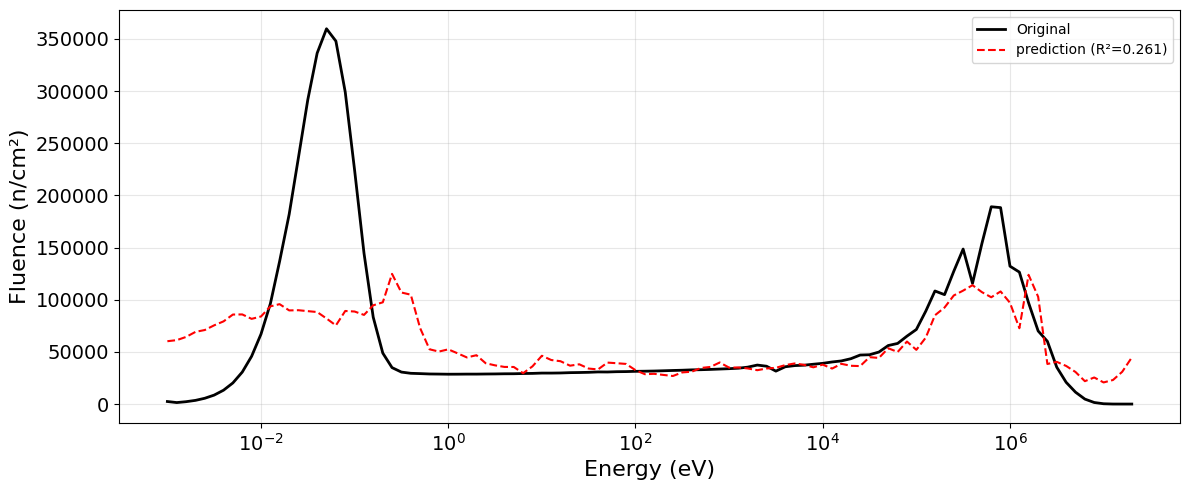

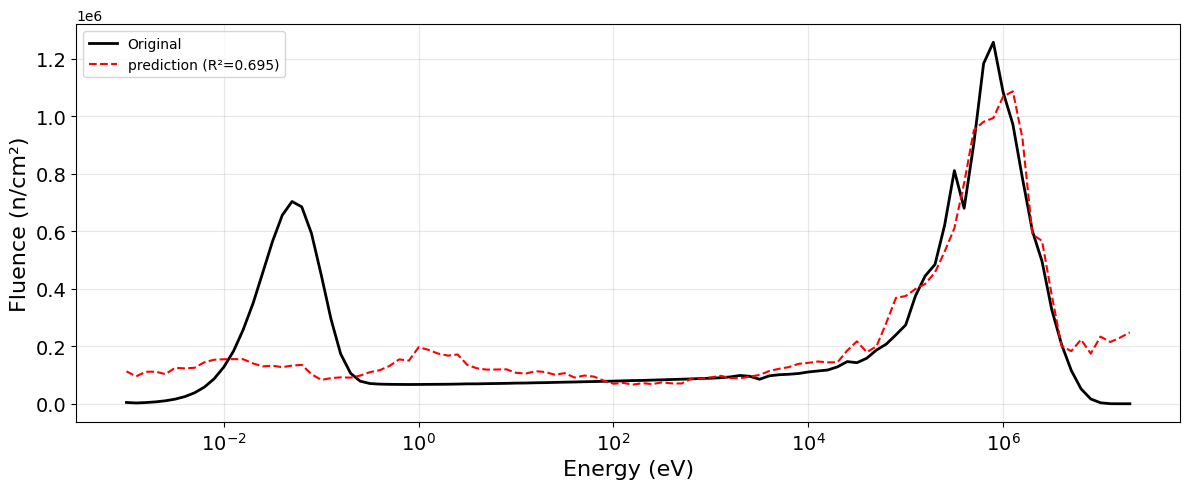

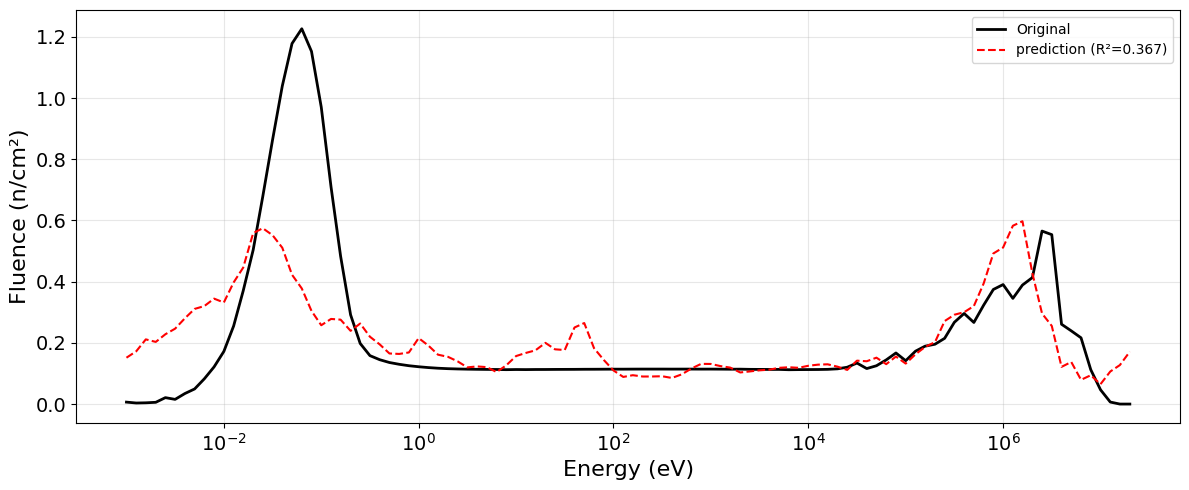

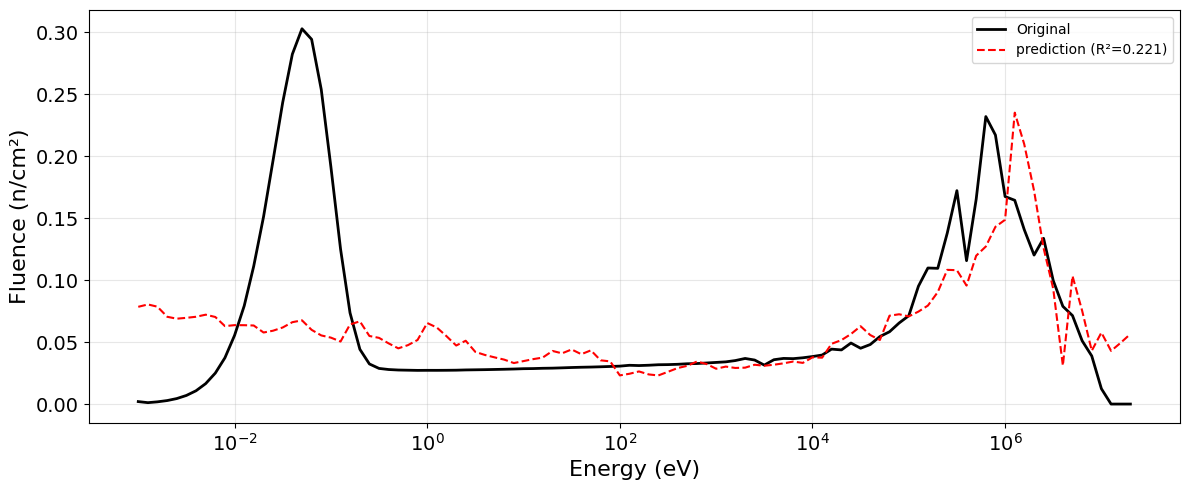

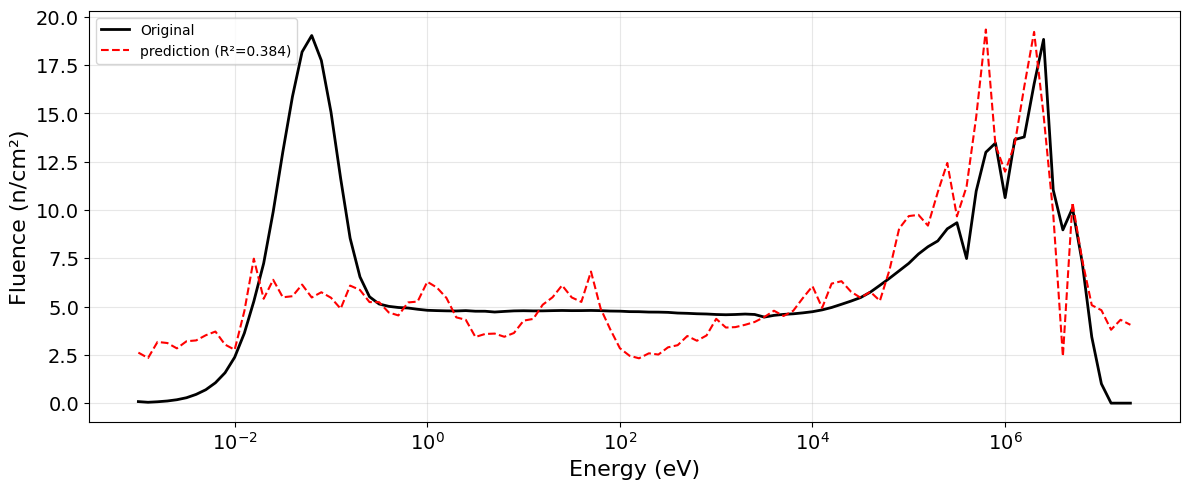

✅ Results saved to xgb_sums_results.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# 1) LOAD TRAINING DATA + NORMALIZE
# --------------------------
try:
    train_df = pd.read_csv("Dataset_modified.csv")
except FileNotFoundError:
    print("Error: 'complete_dataset.csv' not found. Please check the file path.")
    # Dummy training data
    num_samples_train = 100
    num_counts = 50
    num_spectrum = 104
    train_df = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum))
    train_df.columns = [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]

spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Normalize counts and spectra
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

# --------------------------
# 2) TRAIN XGBOOST MODELS (multi-output via loop)
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            n_jobs=-1,
            verbosity=0,
            random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost (multi-output)...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ Model trained successfully.")

# --------------------------
# 3) LOAD TEST DATA + NORMALIZE
# --------------------------
try:
    test_df = pd.read_csv("Test_Dataset_modified.csv")
except FileNotFoundError:
    print("Error: 'Test_Dataset_modified.csv' not found. Please check the file path.")
    # Dummy test data
    num_samples_test = 10
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]

test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 4) ENERGY BINS
# --------------------------
bin_edges = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

n_bins = len(bin_edges)
print(f"Number of spectrum bins = {n_bins}")

# Region masks
thermal_mask    = bin_edges < 0.4
epithermal_mask = (bin_edges >= 0.4) & (bin_edges < 1e5)
fast_mask       = bin_edges >= 1e5
total_mask      = np.ones(n_bins, dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# --------------------------
# 5) PREDICT + EVALUATE
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison
    plt.figure(figsize=(12, 5))
    plt.semilogx(bin_edges, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(bin_edges, y_pred_actual, linestyle="--",
                 label=f"prediction (R²={r2:.3f})", color="red")
    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# --------------------------
# 6) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results.csv", index=False)
print("✅ Results saved to xgb_sums_results.csv")


#Model Performance After Data Cleaning

🔧 Training XGBoost...
✅ XGBoost trained successfully.


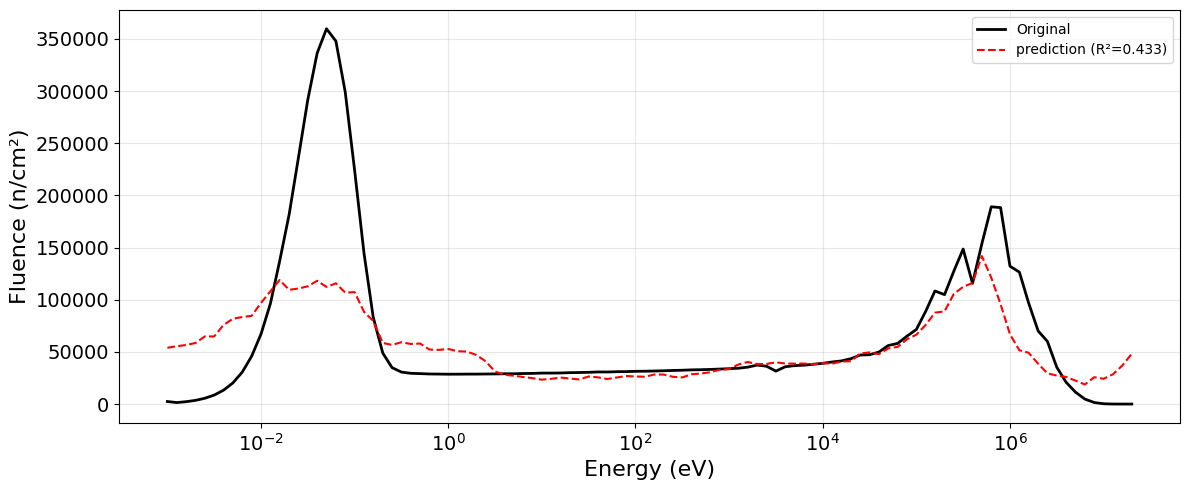

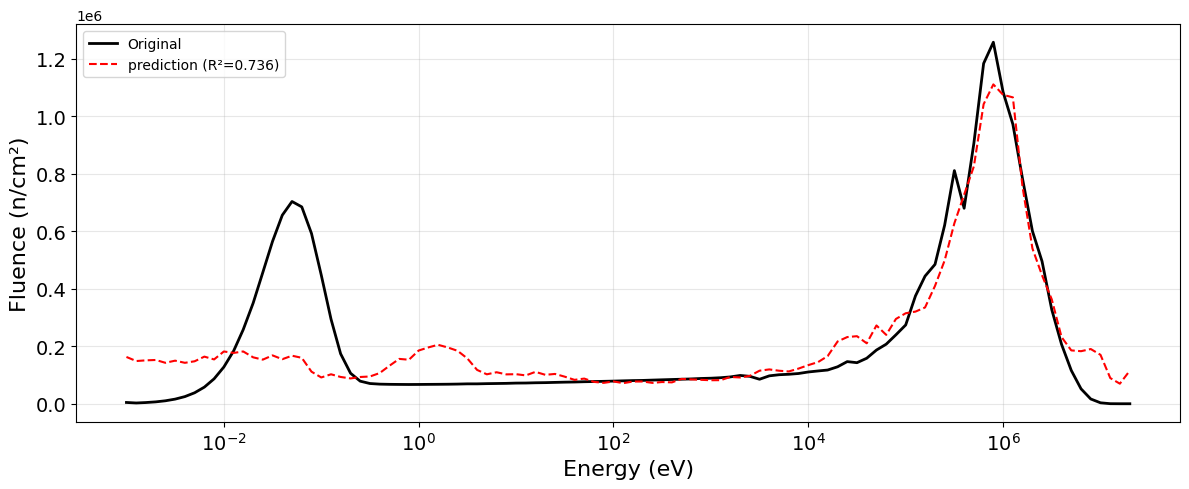

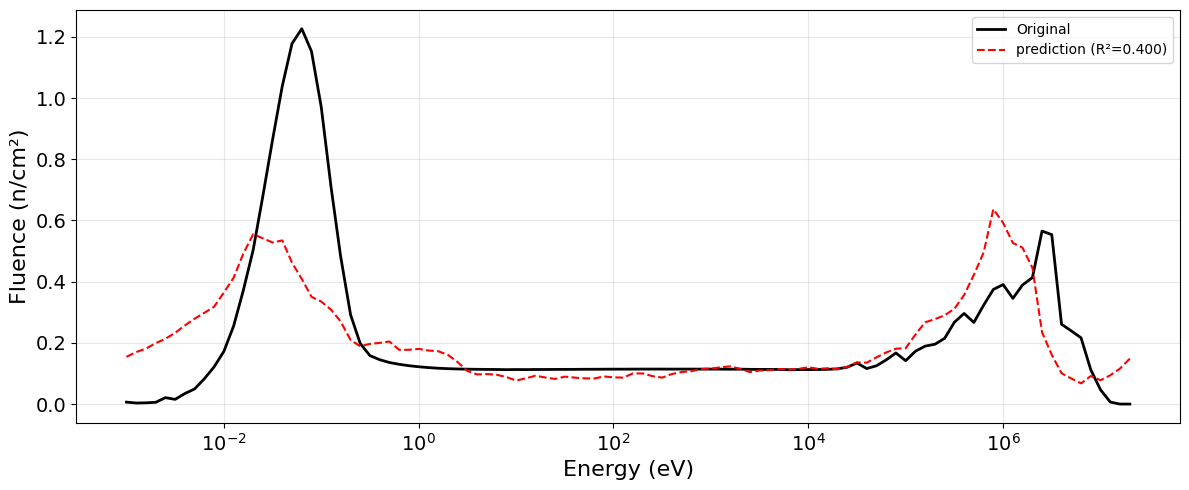

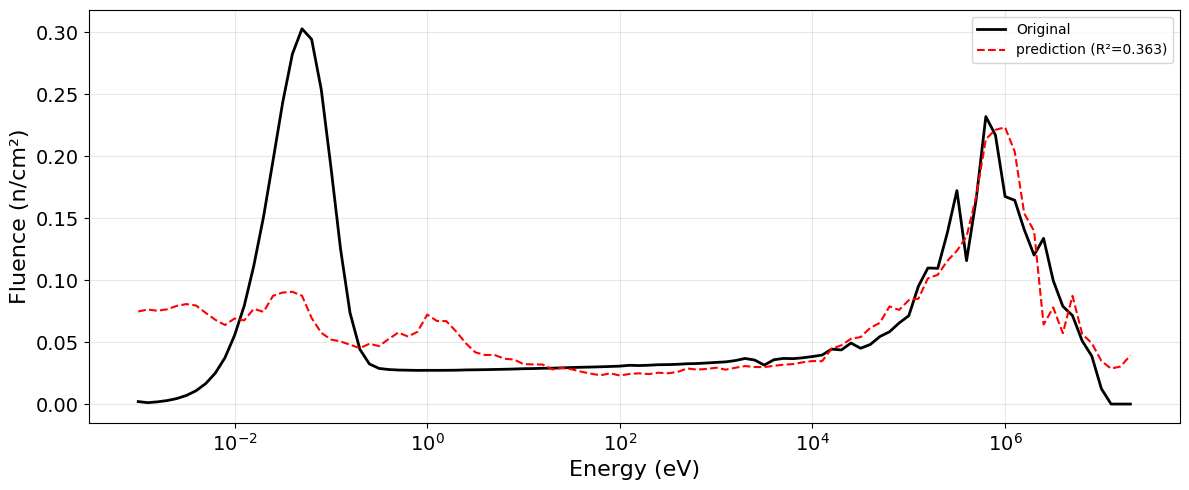

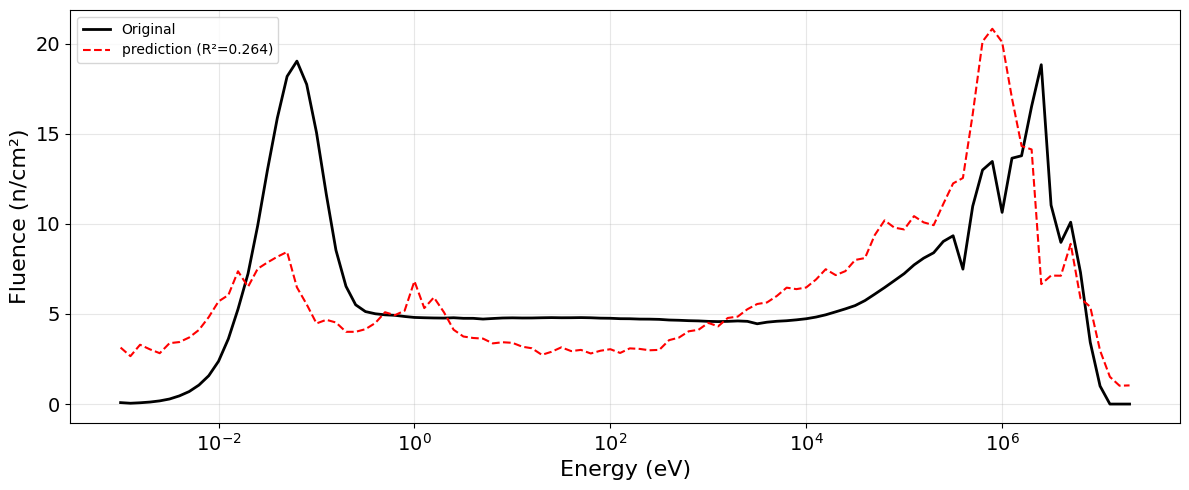

✅ Results saved to xgb_sums_results_filtered.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# 1) LOAD TRAINING DATA + REMOVE BAD IDS + NORMALIZE
# --------------------------
train_df = pd.read_csv("/content/Dataset_modified.csv")
spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# ❌ Remove specific bad spectrum IDs
remove_ids = {5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,
              48,49,51,52,53,54,55,56,57,58,
              68,70,74,75,77,78,79,81,82,
              86,89,90,91,92,96,97,98,99,100,
              102,106,107,108,110,111,112,113,114}
train_df = train_df[~train_df["spectrum_id"].isin(remove_ids)].copy()

# Normalization
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

# ✅ Features = counts only
X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

# --------------------------
# 2) TRAIN XGBOOST MODELS (multi-output)
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0, random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ XGBoost trained successfully.")

# --------------------------
# 3) LOAD TEST DATA + REMOVE BAD IDS + NORMALIZE
# --------------------------
test_df = pd.read_csv("/content/Test_Dataset_modified.csv")
test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# ❌ Remove same bad IDs
test_df = test_df.copy()

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

X_test_all = test_df[count_cols].values

# --------------------------
# 4) ENERGY BINS + REGION MASKS
# --------------------------
energy_bins = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

thermal_mask    = energy_bins < 0.4
epithermal_mask = (energy_bins >= 0.4) & (energy_bins < 1e5)
fast_mask       = energy_bins >= 1e5
total_mask      = np.ones(len(energy_bins), dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# --------------------------
# 5) PREDICT + EVALUATE
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison
    plt.figure(figsize=(12, 5))
    plt.semilogx(energy_bins, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(energy_bins, y_pred_actual, linestyle="--",
                 label=f"prediction (R²={r2:.3f})", color="red")

    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


# --------------------------
# 6) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results_filtered.csv", index=False)
print("✅ Results saved to xgb_sums_results_filtered.csv")


#Model Performance After Data Augmentation

🔧 Augmenting training data...
✅ Training data augmented: 360 samples
🔧 Training XGBoost...
✅ XGBoost trained successfully.


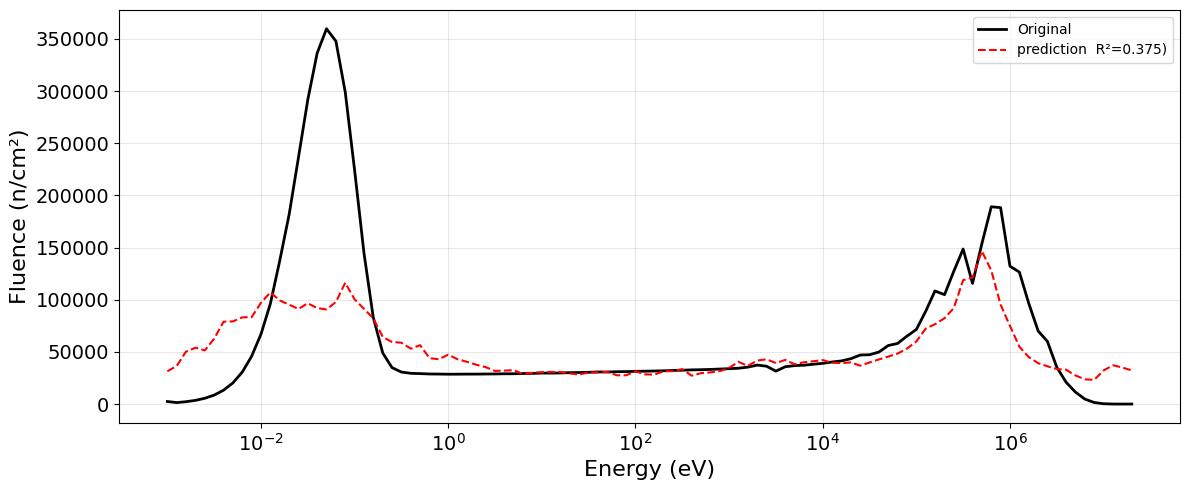

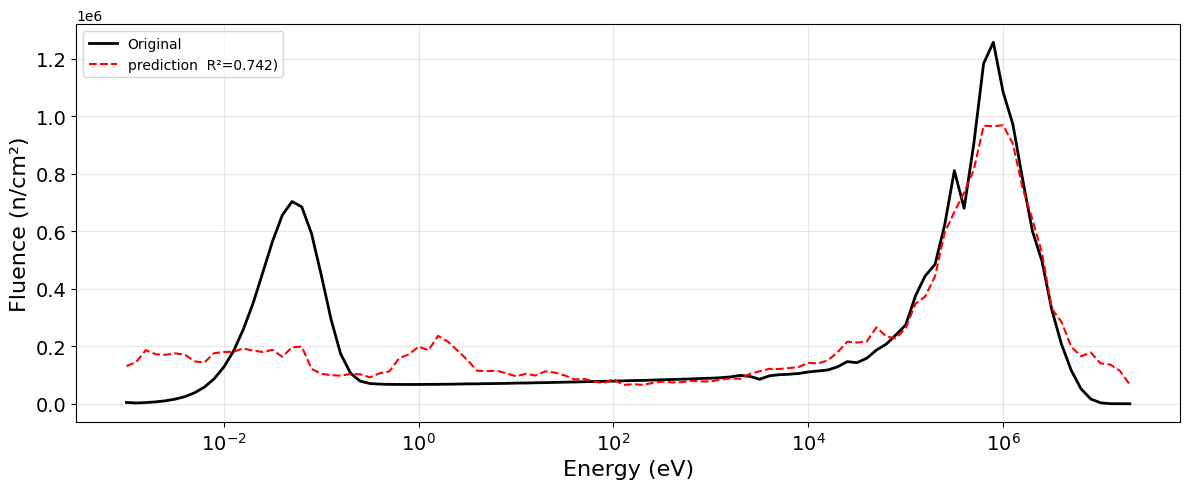

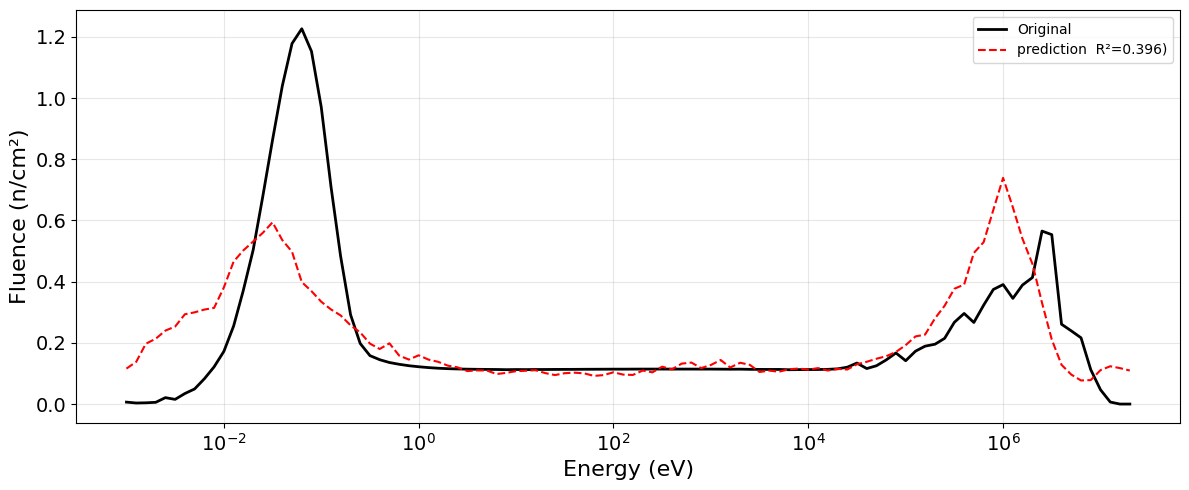

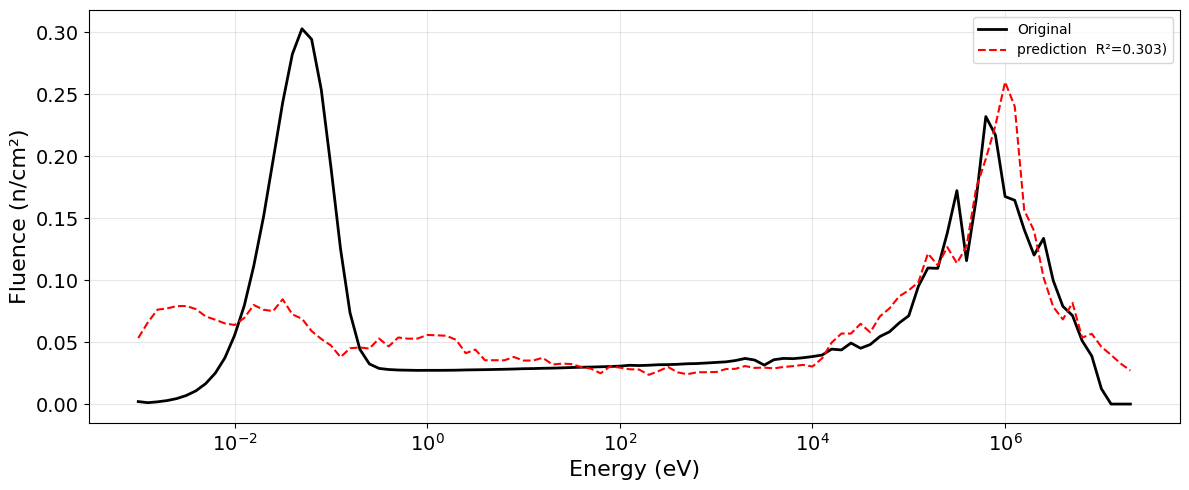

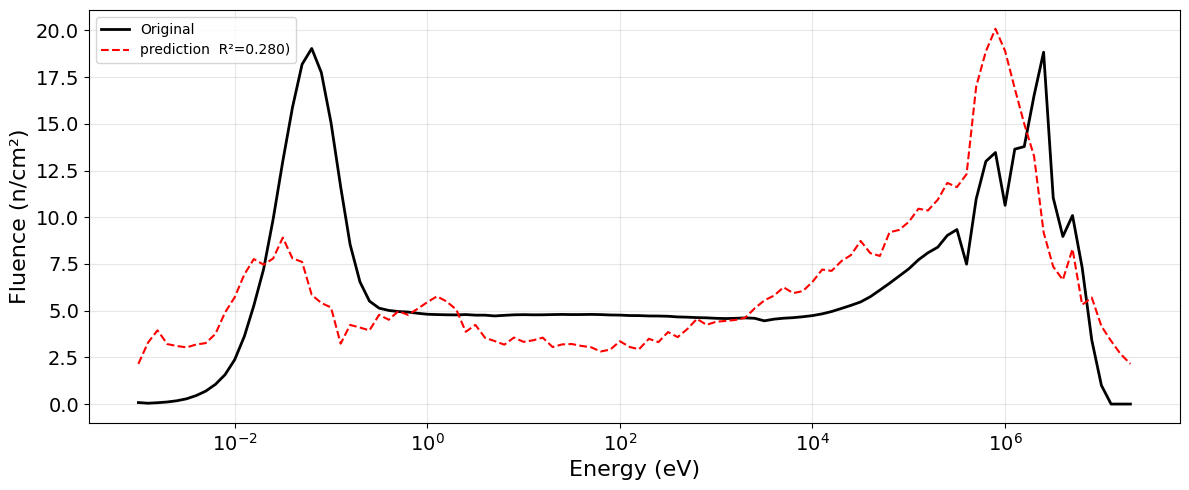

✅ Results saved to xgb_sums_results_augmented.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import find_peaks

# --------------------------
# 1) LOAD TRAINING DATA + REMOVE BAD IDS + NORMALIZE
# --------------------------
train_df = pd.read_csv("/content/Dataset_modified.csv")
spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

remove_ids = {5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,
              48,49,51,52,53,54,55,56,57,58,
              68,70,74,75,77,78,79,81,82,
              86,89,90,91,92,96,97,98,99,100,
              102,106,107,108,110,111,112,113,114}
train_df = train_df[~train_df["spectrum_id"].isin(remove_ids)].copy()

# Normalize
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1
train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

# --------------------------
# 2) DATA AUGMENTATION
# --------------------------
def add_gaussian_noise(spectrum, noise_level=0.05):
    noise = np.random.normal(0, noise_level * np.maximum(spectrum, 0.01), size=spectrum.shape)
    return np.clip(spectrum + noise, 0, None)

def multiplicative_noise(spectrum, scale_range=(0.95, 1.05)):
    return spectrum * np.random.uniform(*scale_range)

def smooth_spectrum(spectrum, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(spectrum, kernel, mode="same")

def random_peak_scaling(spectrum, prominence=0.05, scale_range=(0.8, 1.3)):
    peaks, _ = find_peaks(spectrum, prominence=prominence * np.max(spectrum))
    if len(peaks) == 0: return spectrum
    aug = spectrum.copy()
    selected_peaks = np.random.choice(peaks, size=np.random.randint(1, min(len(peaks), 3)+1), replace=False)
    for p in selected_peaks:
        scale = np.random.uniform(*scale_range)
        aug[p] *= scale
        if p > 0: aug[p-1] *= (scale+1)/2
        if p < len(aug)-1: aug[p+1] *= (scale+1)/2
    return np.clip(aug, 0, None)

def augment_sequentially(spectrum):
    aug = random_peak_scaling(spectrum)
    aug = smooth_spectrum(aug)
    aug = multiplicative_noise(aug)
    aug = add_gaussian_noise(aug)
    return np.clip(aug, 0, None)

def augment_training_data(train_df, n_augments=3):
    augmented_rows = []
    for _, row in train_df.iterrows():
        spectrum = row[spectrum_cols].values.astype(float)
        for _ in range(n_augments):
            augmented_row = row.copy()
            new_spectrum = augment_sequentially(spectrum)
            augmented_row[spectrum_cols] = new_spectrum
            augmented_rows.append(augmented_row)
    return pd.concat([train_df, pd.DataFrame(augmented_rows)], ignore_index=True)

print("🔧 Augmenting training data...")
train_aug = augment_training_data(train_df, n_augments=5)
print(f"✅ Training data augmented: {len(train_aug)} samples")

# Training arrays
X_train = train_aug[count_cols].values
Y_train = train_aug[spectrum_cols].values

# --------------------------
# 3) TRAIN XGBOOST MODELS
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0, random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ XGBoost trained successfully.")

# --------------------------
# 4) LOAD TEST DATA + NORMALIZE
# --------------------------
test_df = pd.read_csv("/content/Test_Dataset_modified.csv")
test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")


test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1
test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 5) ENERGY BINS + REGION MASKS
# --------------------------
energy_bins = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

thermal_mask    = energy_bins < 0.4
epithermal_mask = (energy_bins >= 0.4) & (energy_bins < 1e5)
fast_mask       = energy_bins >= 1e5
total_mask      = np.ones(len(energy_bins), dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# --------------------------
# 6) PREDICT + EVALUATE
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot comparison
    plt.figure(figsize=(12, 5))
    plt.semilogx(energy_bins, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(energy_bins, y_pred_actual, linestyle="--",
                 label=f"prediction  R²={r2:.3f})", color="red")
    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# --------------------------
# 7) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results_augmented.csv", index=False)
print("✅ Results saved to xgb_sums_results_augmented.csv")


#Model Performance After Collecting More Data

🔧 Training XGBoost (no augmentation)...
✅ Model trained successfully.
Number of spectrum bins = 104
thermal: 27 bins
epithermal: 53 bins
fast: 24 bins
total: 104 bins


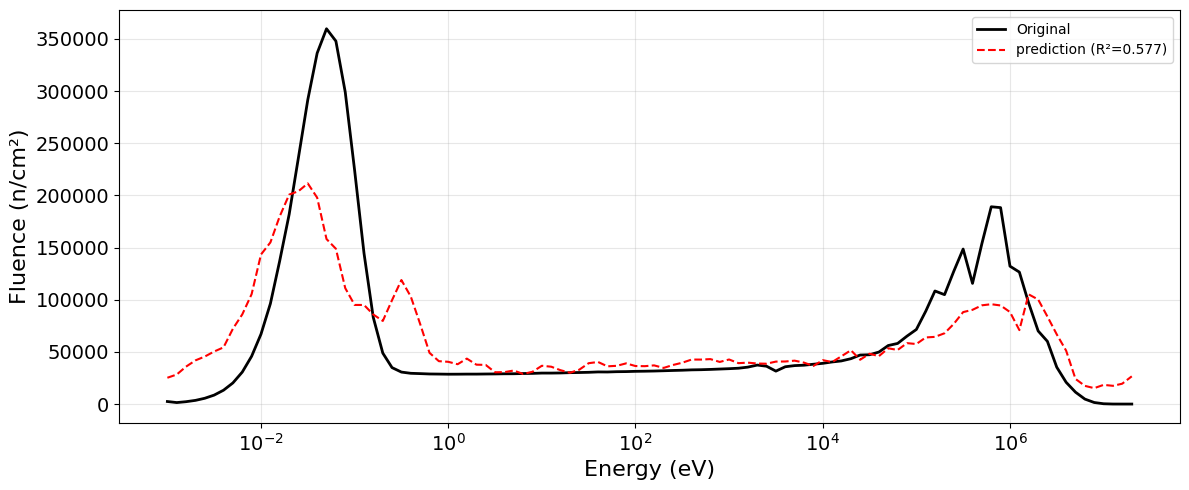

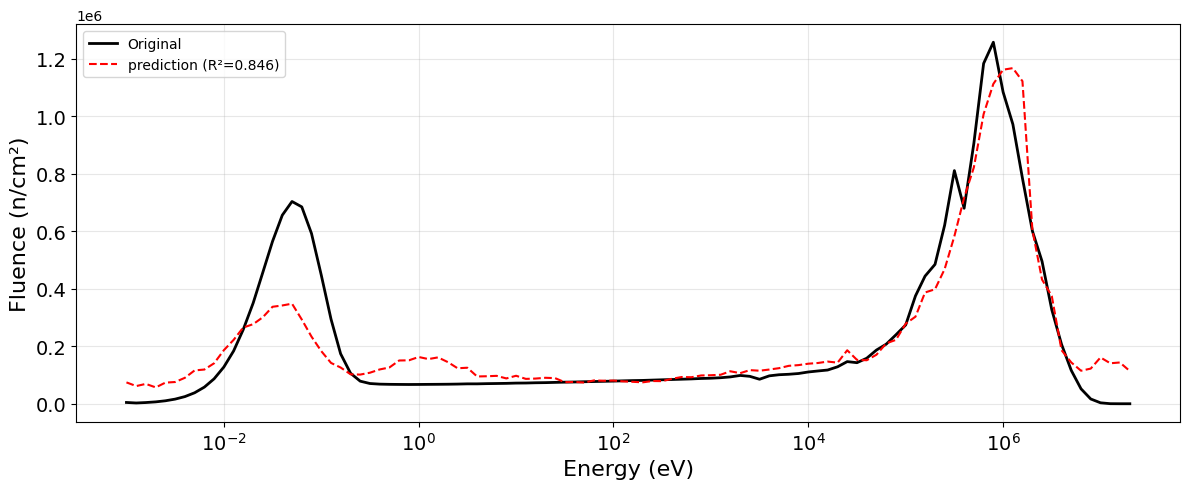

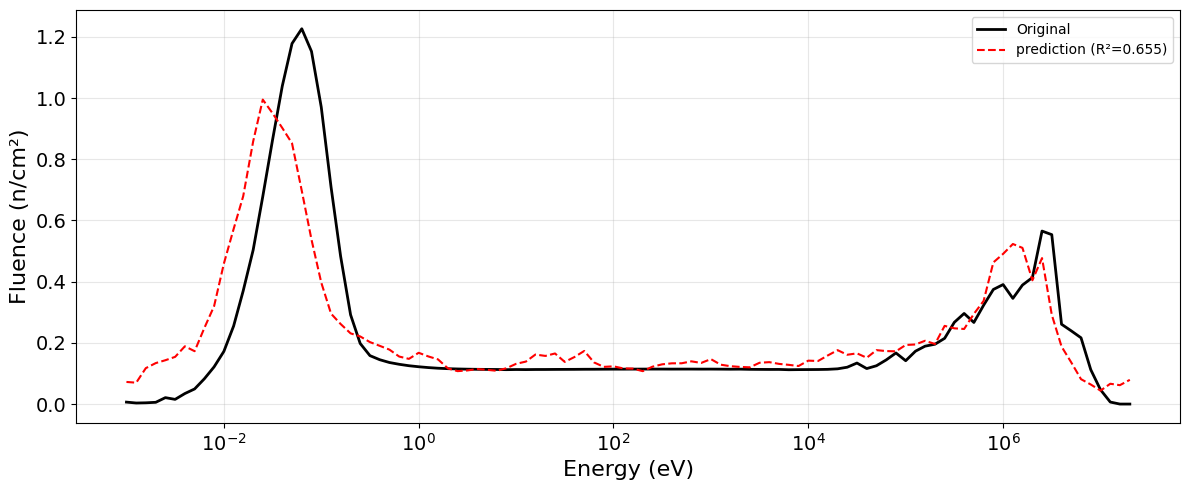

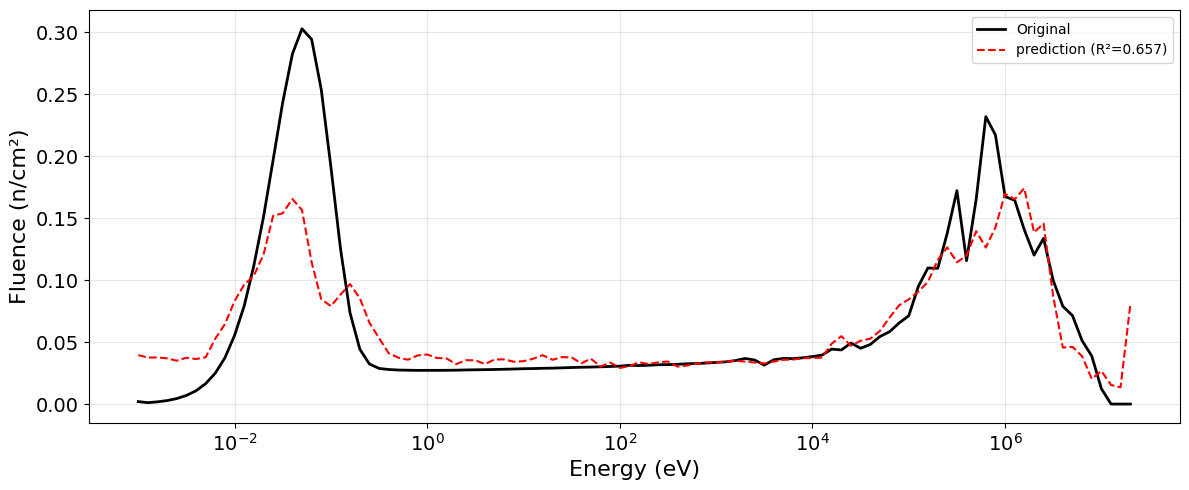

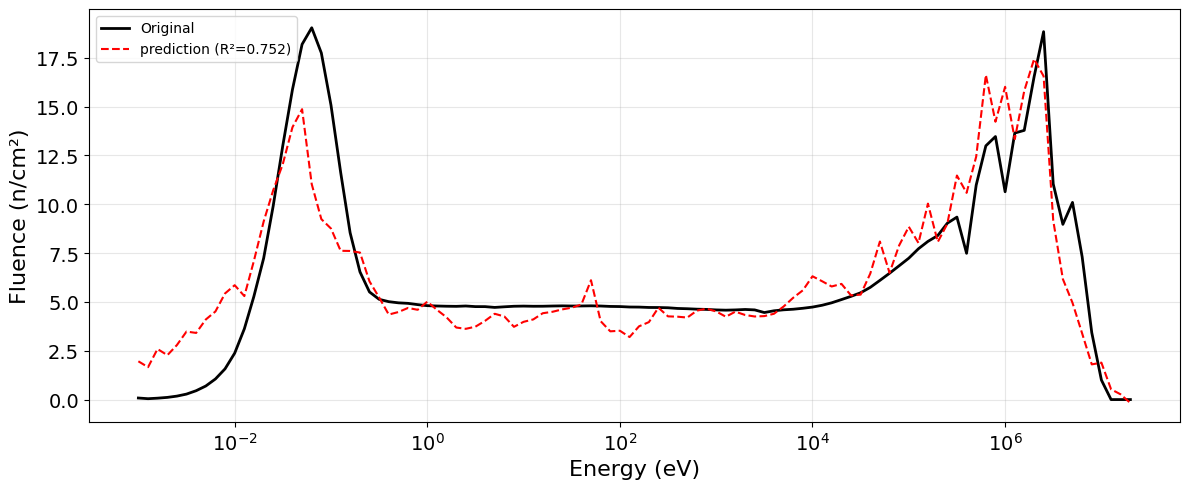

✅ Results saved to xgb_sums_results.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import  r2_score

# --------------------------
# 1) LOAD TRAINING DATA + NORMALIZE
# --------------------------
# Note: You'll need to replace the file paths with the actual location of your data.
try:
    train_df = pd.read_csv("complete_dataset.csv")
except FileNotFoundError:
    print("Error: 'complete_dataset.csv' not found. Please check the file path.")
    # Create dummy data to allow the script to run for demonstration
    print("Creating dummy training data...")
    num_samples_train = 100
    num_counts = 50
    num_spectrum = 104
    train_df = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum))
    train_df.columns = [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]


spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Normalization
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

# --------------------------
# 2) TRAIN MODEL (NO AUGMENTATION)
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost (no augmentation)...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ Model trained successfully.")

# --------------------------
# 3) LOAD TEST DATA + NORMALIZE
# --------------------------
try:
    test_df = pd.read_csv("Test_Dataset_modified.csv")
except FileNotFoundError:
    print("Error: 'Test_Dataset_modified.csv' not found. Please check the file path.")
    # Create dummy data to allow the script to run for demonstration
    print("Creating dummy test data...")
    num_samples_test = 10
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]


test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 4) ENERGY BINS (CORRECTED)
# --------------------------
bin_edges = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

# FIX 1: Correctly define n_bins. It should be the length of the energy points array.
n_bins = len(bin_edges) # This is 104, matching the number of spectrum columns.
print(f"Number of spectrum bins = {n_bins}")

# FIX 2: Define masks with length 104 by using the full `bin_edges` array.
thermal_mask    = bin_edges < 0.4
epithermal_mask = (bin_edges >= 0.4) & (bin_edges < 1e5)
fast_mask       = bin_edges >= 1e5
total_mask      = np.ones(n_bins, dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# print region bin counts to confirm
for region, mask in region_masks.items():
    print(f"{region}: {np.sum(mask)} bins")


# --------------------------
# 5) PREDICT + EVALUATE (CORRECTED)
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total


    r2 = r2_score(y_true_actual, y_pred_actual)

    # Compute sums in regions
    row_res = {"spectrum_id": row["spectrum_id"], "R2": r2}
    for region, mask in region_masks.items():
        # This will now work correctly as len(mask) == len(y_true_actual)
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison
    plt.figure(figsize=(12, 5))
    # FIX 3: Use the full `bin_edges` array for plotting.
    plt.semilogx(bin_edges, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(bin_edges, y_pred_actual, linestyle="--",
                 label=f"prediction (R²={r2:.3f})", color="red")

    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# --------------------------
# 6) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results.csv", index=False)
print("✅ Results saved to xgb_sums_results.csv")

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1) LOAD TRAINING DATA + NORMALIZE
# --------------------------
try:
    train_df = pd.read_csv("complete_dataset.csv")
except FileNotFoundError:
    print("Error: 'complete_dataset.csv' not found. Please check the file path.")
    print("Creating dummy training data...")
    num_samples_train = 1000  # Increased for better optimization
    num_counts = 50
    num_spectrum = 104
    train_df = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum))
    train_df.columns = [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]

spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Normalization
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

# Split data for validation during optimization
X_train_opt, X_val_opt, Y_train_opt, Y_val_opt = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train_opt.shape}")
print(f"Validation data shape: {X_val_opt.shape}")

# --------------------------
# 2) OPTUNA OPTIMIZATION FUNCTIONS
# --------------------------
def train_xgb_multioutput_with_params(X, Y, params):
    """Train XGBoost models with given parameters"""
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(**params, verbosity=0, n_jobs=1)  # n_jobs=1 for stability during optimization
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    """Predict using trained models"""
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

def evaluate_model(models, X_val, Y_val):
    """Evaluate model performance"""
    Y_pred = predict_xgb_multioutput(models, X_val)

    # Calculate average MSE across all outputs
    mse_scores = []
    for j in range(Y_val.shape[1]):
        mse = mean_squared_error(Y_val[:, j], Y_pred[:, j])
        mse_scores.append(mse)

    return np.mean(mse_scores)

def objective(trial):
    """Optuna objective function"""
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
        'tree_method': 'hist',
        'random_state': 42
    }

    try:
        # Train models with current parameters
        models = train_xgb_multioutput_with_params(X_train_opt, Y_train_opt, params)

        # Evaluate on validation set
        avg_mse = evaluate_model(models, X_val_opt, Y_val_opt)

        return avg_mse

    except Exception as e:
        print(f"Trial failed with error: {e}")
        return float('inf')

# --------------------------
# 3) RUN OPTUNA OPTIMIZATION
# --------------------------
print("🔧 Starting Optuna hyperparameter optimization...")
print("This may take several minutes depending on n_trials...")

# Create study
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)

# Optimize
n_trials = 100  # Adjust based on your computational budget
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Display results
print("\n✅ Optimization completed!")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best MSE: {study.best_value:.6f}")
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# --------------------------
# 4) TRAIN FINAL MODEL WITH BEST PARAMETERS
# --------------------------
print("\n🔧 Training final model with best parameters...")
best_params = study.best_params.copy()
best_params.update({
    'tree_method': 'hist',
    'n_jobs': -1,
    'verbosity': 0,
    'random_state': 42
})

# Train on full training data
final_models = train_xgb_multioutput_with_params(X_train, Y_train, best_params)
print("✅ Final model trained successfully.")

# --------------------------
# 5) LOAD TEST DATA + NORMALIZE
# --------------------------
try:
    test_df = pd.read_csv("Test_Dataset_modified.csv")
except FileNotFoundError:
    print("Error: 'Test_Dataset_modified.csv' not found. Please check the file path.")
    print("Creating dummy test data...")
    num_samples_test = 20
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]

test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 6) ENERGY BINS (CORRECTED)
# --------------------------
bin_edges = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

n_bins = len(bin_edges)
print(f"Number of spectrum bins = {n_bins}")

thermal_mask    = bin_edges < 0.4
epithermal_mask = (bin_edges >= 0.4) & (bin_edges < 1e5)
fast_mask       = bin_edges >= 1e5
total_mask      = np.ones(n_bins, dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

for region, mask in region_masks.items():
    print(f"{region}: {np.sum(mask)} bins")

# --------------------------
# 7) PREDICT + EVALUATE WITH OPTIMIZED MODEL
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(final_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    # Compute sums in regions
    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison
    plt.figure(figsize=(12, 5))
    plt.semilogx(bin_edges, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(bin_edges, y_pred_actual, linestyle="--",
                 label=f"Optimized XGBoost (MSE={mse:.2e}, R²={r2:.3f})", color="red")
    plt.title(f"Optimized Spectrum Prediction | ID: {row['spectrum_id']}")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Flux (sum scale)")
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.tight_layout()
    plt.show()

# --------------------------
# 8) SAVE RESULTS AND OPTIMIZATION HISTORY
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_optimized_results.csv", index=False)

# Save optimization history
optimization_df = study.trials_dataframe()
optimization_df.to_csv("optuna_optimization_history.csv", index=False)

# Save best parameters
best_params_df = pd.DataFrame([study.best_params])
best_params_df.to_csv("best_xgb_parameters.csv", index=False)

print("✅ Results saved to:")
print("  - xgb_optimized_results.csv")
print("  - optuna_optimization_history.csv")
print("  - best_xgb_parameters.csv")

# --------------------------
# 9) PLOT OPTIMIZATION HISTORY
# --------------------------
plt.figure(figsize=(12, 4))

# Plot optimization history
plt.subplot(1, 2, 1)
trials_df = study.trials_dataframe()
plt.plot(trials_df['number'], trials_df['value'])
plt.xlabel('Trial')
plt.ylabel('MSE')
plt.title('Optuna Optimization History')
plt.grid(alpha=0.3)

# Plot parameter importance
plt.subplot(1, 2, 2)
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    plt.barh(params, values)
    plt.xlabel('Importance')
    plt.title('Parameter Importance')
except:
    plt.text(0.5, 0.5, 'Parameter importance\nnot available',
             ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

print(f"\n🎯 Optimization Summary:")
print(f"Best MSE achieved: {study.best_value:.6f}")
print(f"Total trials run: {len(study.trials)}")
print(f"Best trial: #{study.best_trial.number}")

[I 2025-09-28 09:50:17,575] A new study created in memory with name: no-name-34a9a340-49aa-482d-9d7d-23809d5b23fb


Training data shape: (142, 12)
Validation data shape: (36, 12)
🔧 Starting Optuna hyperparameter optimization...
This may take several minutes depending on n_trials...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-28 09:50:26,939] Trial 0 finished with value: 0.0001838875643763517 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'colsample_bynode': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'min_child_weight': 8, 'gamma': 1.5320059381854043e-08}. Best is trial 0 with value: 0.0001838875643763517.
[I 2025-09-28 09:51:02,067] Trial 1 finished with value: 0.00010322926019797193 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.020589728197687916, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'colsample_bylevel': 0.7216968971838151, 'colsample_bynode': 0.8099025726528951, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06, 'min_child_weight': 7, 'gamma': 1.8007140198129195e-07}. Best is trial 1 with value: 0.0001032292601

TypeError: xgboost.sklearn.XGBRegressor() got multiple values for keyword argument 'verbosity'

🎯 Using Optuna-optimized parameters:
  n_estimators: 850
  max_depth: 10
  learning_rate: 0.016154891031867704
  subsample: 0.6170678875749663
  colsample_bytree: 0.9347281412817657
  colsample_bylevel: 0.8638396843442715
  colsample_bynode: 0.9223743862879897
  reg_alpha: 2.48733310367823e-06
  reg_lambda: 1.0563042584348388
  min_child_weight: 10
  gamma: 2.107003202619333e-08
✅ Loaded training data: (178, 117)
Training features shape: (178, 12)
Training targets shape: (178, 104)
No saved models found. Training new models...
🔧 Training 104 XGBoost models with optimized parameters...
  Training model 20/104...
  Training model 40/104...
  Training model 60/104...
  Training model 80/104...
  Training model 100/104...
✅ Models saved to models/
✅ Loaded test data: (5, 117)
Number of spectrum bins = 104
thermal: 27 bins
epithermal: 53 bins
fast: 24 bins
total: 104 bins

📊 Analyzing Feature Importance (Top 15 features)...

Top features by average importance:
  count_5: 0.1152 ± 0.0976
  c

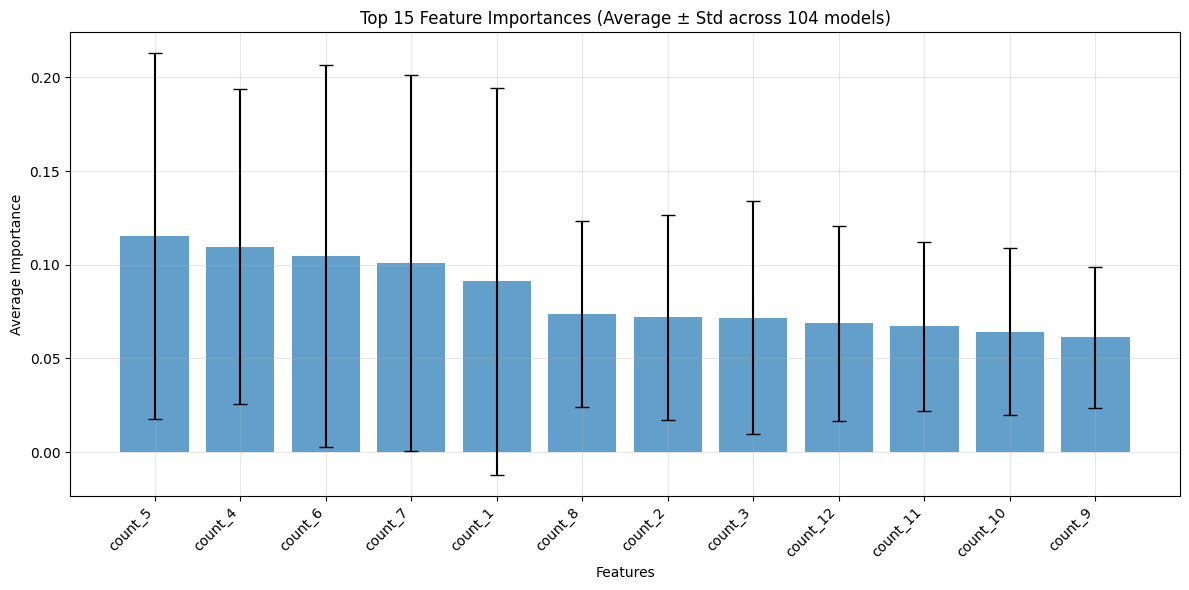


🔬 Evaluating on 5 test samples...


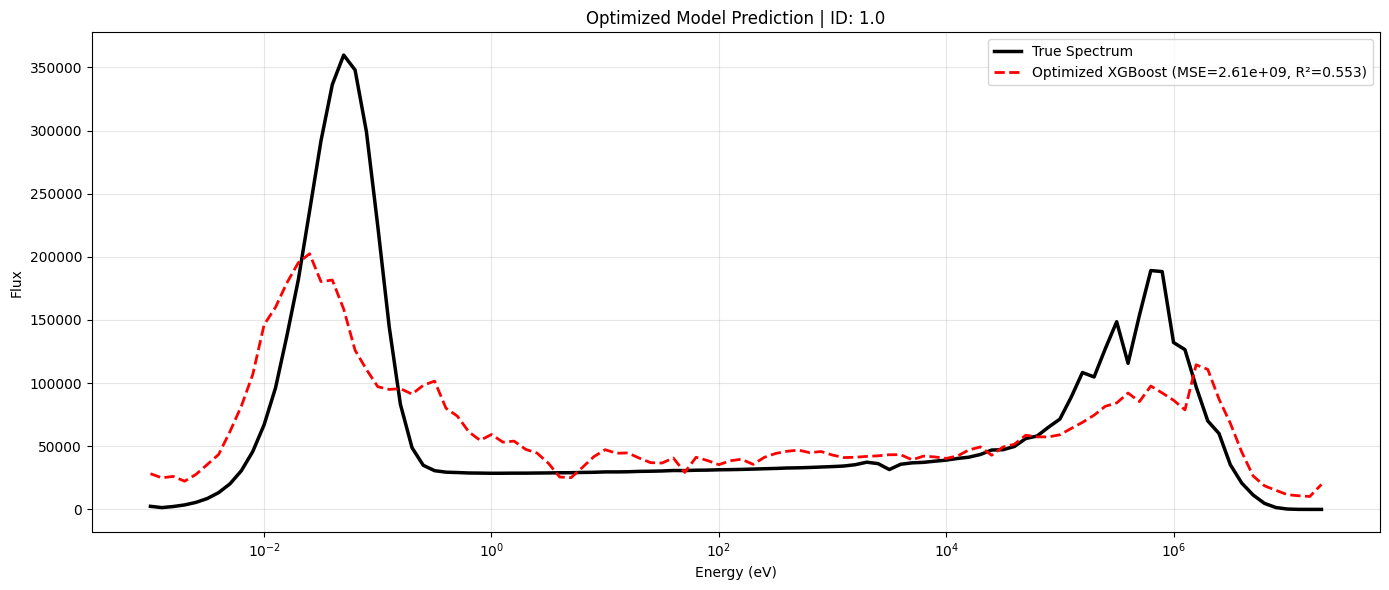

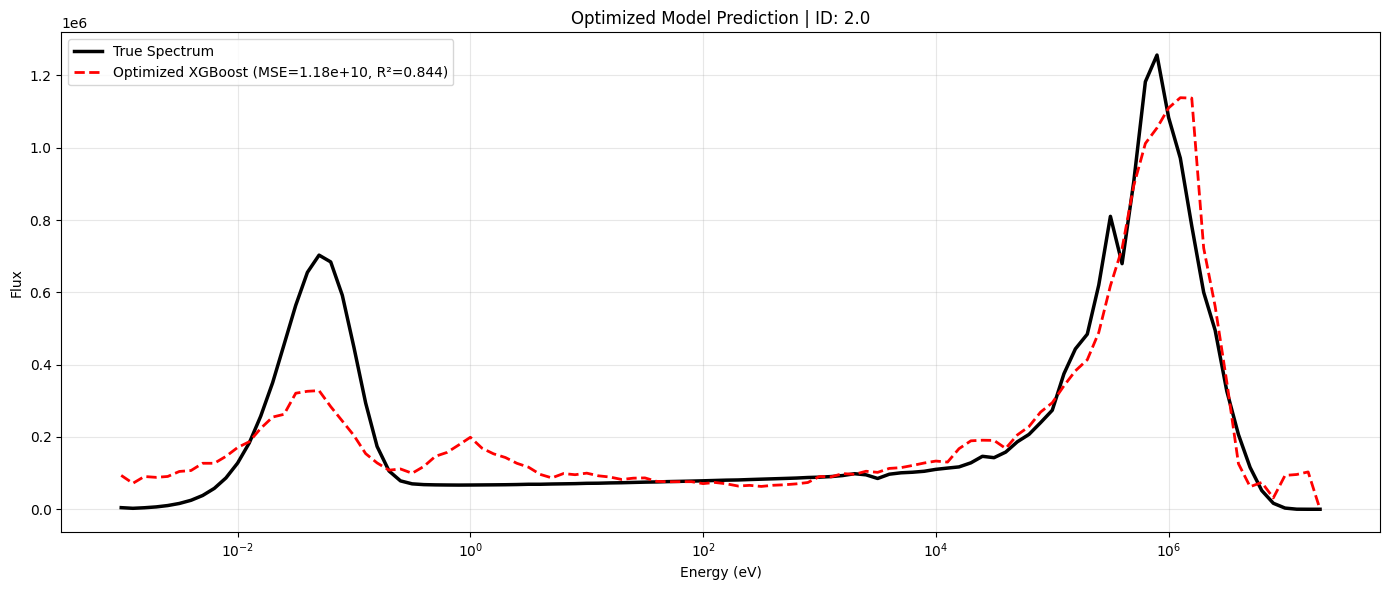

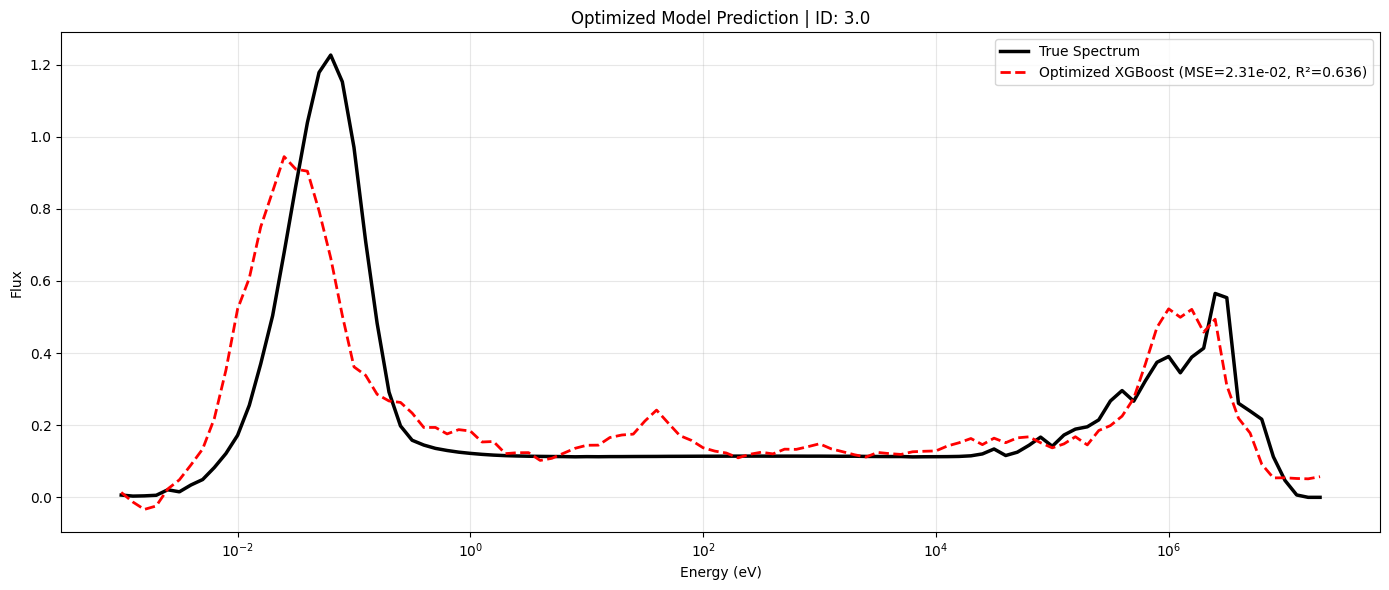

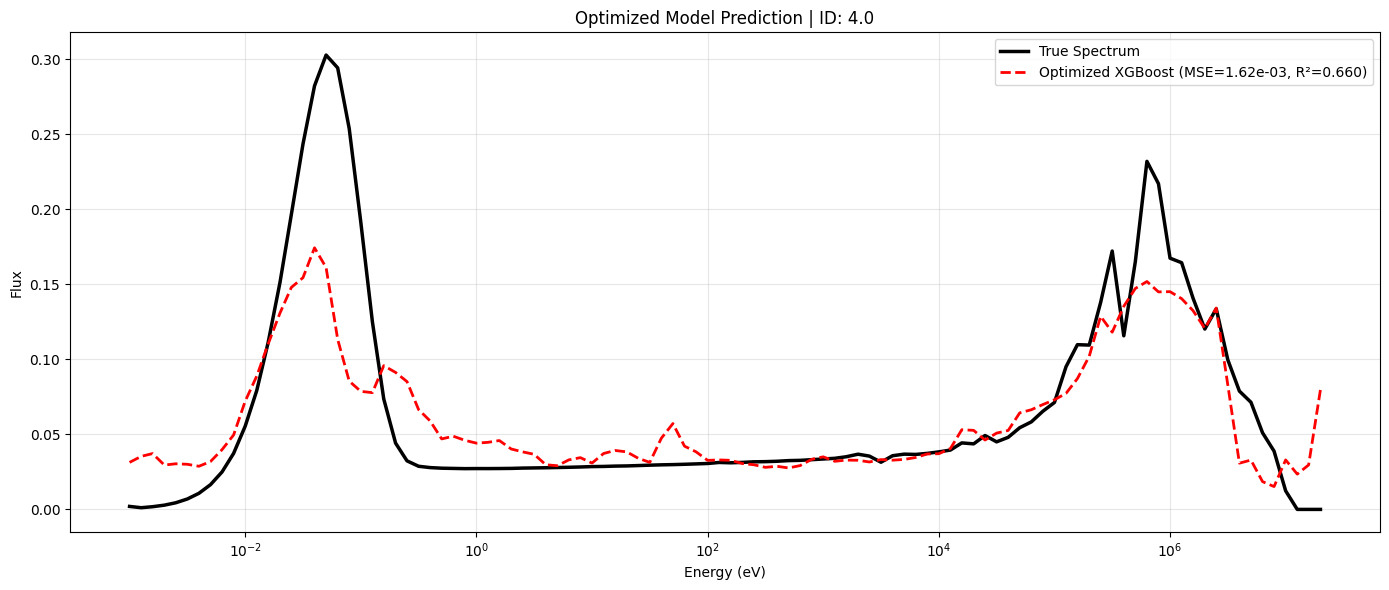

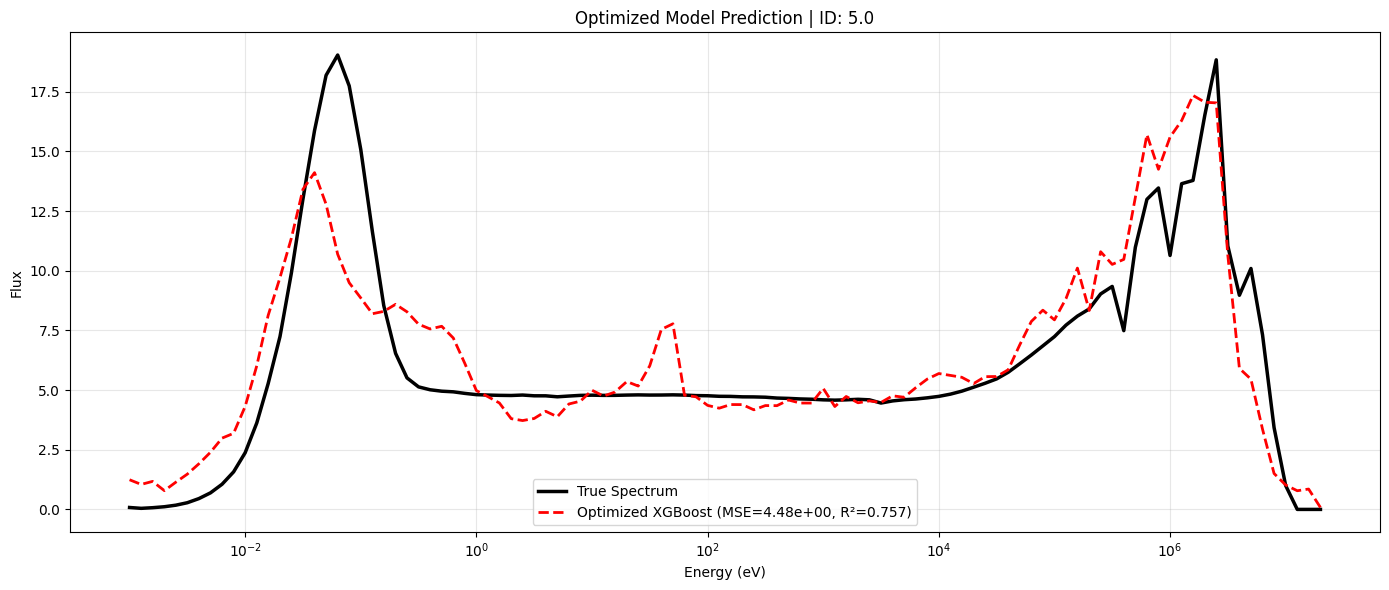


📈 Model Performance Summary:
Average MSE: 2.89e+09 ± 4.58e+09
Average R²:  0.690 ± 0.101
Best R²:     0.844
Worst R²:    0.553

Thermal region relative differences:
  Mean: -11.5% ± 10.0%
  Range: [-24.6%, 0.4%]

Epithermal region relative differences:
  Mean: 19.6% ± 9.0%
  Range: [5.5%, 27.0%]

Fast region relative differences:
  Mean: -5.2% ± 10.3%
  Range: [-19.0%, 6.0%]

Total region relative differences:
  Mean: -0.4% ± 4.8%
  Range: [-7.3%, 4.3%]
✅ Results saved to:
  - xgb_production_results.csv
  - feature_importance_analysis.csv
  - model_performance_summary.pkl
  - models/ directory (trained models)

🎯 Production model ready with optimized parameters!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os
from datetime import datetime

# --------------------------
# OPTIMIZED PARAMETERS FROM OPTUNA
# --------------------------
BEST_PARAMS = {
    'n_estimators': 850,
    'max_depth': 10,
    'learning_rate': 0.016154891031867704,
    'subsample': 0.6170678875749663,
    'colsample_bytree': 0.9347281412817657,
    'colsample_bylevel': 0.8638396843442715,
    'colsample_bynode': 0.9223743862879897,
    'reg_alpha': 2.48733310367823e-06,
    'reg_lambda': 1.0563042584348388,
    'min_child_weight': 10,
    'gamma': 2.107003202619333e-08,
    'tree_method': 'hist',
    'n_jobs': -1,
    'verbosity': 0,
    'random_state': 42
}

print("🎯 Using Optuna-optimized parameters:")
for key, value in BEST_PARAMS.items():
    if key not in ['tree_method', 'n_jobs', 'verbosity', 'random_state']:
        print(f"  {key}: {value}")

# --------------------------
# 1) LOAD TRAINING DATA + NORMALIZE
# --------------------------
try:
    train_df = pd.read_csv("complete_dataset.csv")
    print(f"✅ Loaded training data: {train_df.shape}")
except FileNotFoundError:
    print("Error: 'complete_dataset.csv' not found. Please check the file path.")
    print("Creating dummy training data...")
    num_samples_train = 1000
    num_counts = 50
    num_spectrum = 104
    train_df = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum))
    train_df.columns = [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]

spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Normalization
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

print(f"Training features shape: {X_train.shape}")
print(f"Training targets shape: {Y_train.shape}")

# --------------------------
# 2) TRAIN OPTIMIZED MODEL WITH MODEL PERSISTENCE
# --------------------------
def train_xgb_multioutput_optimized(X, Y, params, model_save_path="models/"):
    """Train XGBoost models with optimized parameters and save them"""

    # Create models directory if it doesn't exist
    os.makedirs(model_save_path, exist_ok=True)

    models = []
    print(f"🔧 Training {Y.shape[1]} XGBoost models with optimized parameters...")

    for j in range(Y.shape[1]):
        if (j + 1) % 20 == 0:
            print(f"  Training model {j+1}/{Y.shape[1]}...")

        model = XGBRegressor(**params)
        model.fit(X, Y[:, j])
        models.append(model)

        # Save individual model
        model_file = os.path.join(model_save_path, f"xgb_model_{j:03d}.pkl")
        with open(model_file, 'wb') as f:
            pickle.dump(model, f)

    # Save all models together
    all_models_file = os.path.join(model_save_path, "all_xgb_models.pkl")
    with open(all_models_file, 'wb') as f:
        pickle.dump(models, f)

    # Save training metadata
    metadata = {
        'n_models': len(models),
        'training_shape': X.shape,
        'target_shape': Y.shape,
        'parameters': params,
        'timestamp': datetime.now().isoformat(),
        'feature_columns': count_cols,
        'target_columns': spectrum_cols
    }

    metadata_file = os.path.join(model_save_path, "training_metadata.pkl")
    with open(metadata_file, 'wb') as f:
        pickle.dump(metadata, f)

    print(f"✅ Models saved to {model_save_path}")
    return models

def load_xgb_models(model_save_path="models/"):
    """Load trained XGBoost models"""
    try:
        all_models_file = os.path.join(model_save_path, "all_xgb_models.pkl")
        with open(all_models_file, 'rb') as f:
            models = pickle.load(f)

        metadata_file = os.path.join(model_save_path, "training_metadata.pkl")
        with open(metadata_file, 'rb') as f:
            metadata = pickle.load(f)

        print(f"✅ Loaded {len(models)} models from {model_save_path}")
        print(f"   Trained on: {metadata['timestamp']}")
        return models, metadata
    except FileNotFoundError:
        print("No saved models found. Training new models...")
        return None, None

def predict_xgb_multioutput(models, X):
    """Predict using trained models"""
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

# Try to load existing models, otherwise train new ones
models, metadata = load_xgb_models()
if models is None:
    models = train_xgb_multioutput_optimized(X_train, Y_train, BEST_PARAMS)
else:
    print("Using previously trained models. To retrain, delete the 'models/' directory.")

# --------------------------
# 3) LOAD TEST DATA + NORMALIZE
# --------------------------
try:
    test_df = pd.read_csv("Test_Dataset_modified.csv")
    print(f"✅ Loaded test data: {test_df.shape}")
except FileNotFoundError:
    print("Error: 'Test_Dataset_modified.csv' not found. Please check the file path.")
    print("Creating dummy test data...")
    num_samples_test = 20
    test_df = pd.DataFrame(np.random.rand(num_samples_test, len(count_cols) + len(spectrum_cols) + 1))
    test_df.columns = ["spectrum_id"] + count_cols + spectrum_cols
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]

test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 4) ENERGY BINS AND REGION MASKS
# --------------------------
bin_edges = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

n_bins = len(bin_edges)
print(f"Number of spectrum bins = {n_bins}")

thermal_mask    = bin_edges < 0.4
epithermal_mask = (bin_edges >= 0.4) & (bin_edges < 1e5)
fast_mask       = bin_edges >= 1e5
total_mask      = np.ones(n_bins, dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

for region, mask in region_masks.items():
    print(f"{region}: {np.sum(mask)} bins")

# --------------------------
# 5) FEATURE IMPORTANCE ANALYSIS
# --------------------------
def analyze_feature_importance(models, feature_names, top_n=10):
    """Analyze feature importance across all models"""
    print(f"\n📊 Analyzing Feature Importance (Top {top_n} features)...")

    # Calculate average importance across all models
    all_importances = []
    for model in models:
        all_importances.append(model.feature_importances_)

    avg_importance = np.mean(all_importances, axis=0)
    importance_std = np.std(all_importances, axis=0)

    # Create dataframe for analysis
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': avg_importance,
        'importance_std': importance_std
    })

    importance_df = importance_df.sort_values('importance_mean', ascending=False)

    # Display top features
    print("\nTop features by average importance:")
    for i, row in importance_df.head(top_n).iterrows():
        print(f"  {row['feature']}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    top_features = importance_df.head(top_n)

    plt.bar(range(len(top_features)), top_features['importance_mean'],
            yerr=top_features['importance_std'], capsize=5, alpha=0.7)
    plt.xticks(range(len(top_features)), top_features['feature'], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Average Importance')
    plt.title(f'Top {top_n} Feature Importances (Average ± Std across {len(models)} models)')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

    return importance_df

# Analyze feature importance
feature_importance_df = analyze_feature_importance(models, count_cols, top_n=15)
feature_importance_df.to_csv("feature_importance_analysis.csv", index=False)

# --------------------------
# 6) PREDICT + EVALUATE WITH ENHANCED METRICS
# --------------------------
results = []
all_mse_scores = []
all_r2_scores = []

print(f"\n🔬 Evaluating on {len(test_df)} test samples...")

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    all_mse_scores.append(mse)
    all_r2_scores.append(r2)

    # Compute sums in regions
    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison (first 5 samples only to avoid too many plots)
    if idx < 5:
        plt.figure(figsize=(14, 6))
        plt.semilogx(bin_edges, y_true_actual, label="True Spectrum",
                    color="black", linewidth=2.5)
        plt.semilogx(bin_edges, y_pred_actual, linestyle="--",
                     label=f"Optimized XGBoost (R²={r2:.3f})",
                     color="red", linewidth=2)
        plt.title(f"Optimized Model Prediction | ID: {row['spectrum_id']}")
        plt.xlabel("Energy (eV)")
        plt.ylabel("Flux")
        plt.legend()
        plt.grid(alpha=0.3, which="both")
        plt.tight_layout()
        plt.show()

# --------------------------
# 7) COMPREHENSIVE RESULTS SUMMARY
# --------------------------
print(f"\n📈 Model Performance Summary:")
print(f"Average MSE: {np.mean(all_mse_scores):.2e} ± {np.std(all_mse_scores):.2e}")
print(f"Average R²:  {np.mean(all_r2_scores):.3f} ± {np.std(all_r2_scores):.3f}")
print(f"Best R²:     {np.max(all_r2_scores):.3f}")
print(f"Worst R²:    {np.min(all_r2_scores):.3f}")

# Regional performance analysis
results_df = pd.DataFrame(results)
for region in ["thermal", "epithermal", "fast", "total"]:
    rel_diffs = results_df[f"{region}_sum_reldiff(%)"]
    print(f"\n{region.capitalize()} region relative differences:")
    print(f"  Mean: {rel_diffs.mean():.1f}% ± {rel_diffs.std():.1f}%")
    print(f"  Range: [{rel_diffs.min():.1f}%, {rel_diffs.max():.1f}%]")

# --------------------------
# 8) SAVE COMPREHENSIVE RESULTS
# --------------------------
results_df.to_csv("xgb_production_results.csv", index=False)

# Save summary statistics
summary_stats = {
    'model_parameters': BEST_PARAMS,
    'performance_metrics': {
        'avg_mse': float(np.mean(all_mse_scores)),
        'std_mse': float(np.std(all_mse_scores)),
        'avg_r2': float(np.mean(all_r2_scores)),
        'std_r2': float(np.std(all_r2_scores)),
        'best_r2': float(np.max(all_r2_scores)),
        'worst_r2': float(np.min(all_r2_scores))
    },
    'regional_performance': {}
}

for region in ["thermal", "epithermal", "fast", "total"]:
    rel_diffs = results_df[f"{region}_sum_reldiff(%)"]
    summary_stats['regional_performance'][region] = {
        'mean_rel_diff': float(rel_diffs.mean()),
        'std_rel_diff': float(rel_diffs.std()),
        'min_rel_diff': float(rel_diffs.min()),
        'max_rel_diff': float(rel_diffs.max())
    }

with open("model_performance_summary.pkl", 'wb') as f:
    pickle.dump(summary_stats, f)

print("✅ Results saved to:")
print("  - xgb_production_results.csv")
print("  - feature_importance_analysis.csv")
print("  - model_performance_summary.pkl")
print("  - models/ directory (trained models)")

print(f"\n🎯 Production model ready with optimized parameters!")

#comparaison


✅ All dataset files loaded successfully
METHOD 1: Basic XGBoost (Dataset_modified.csv)
Training Method 1...
✅ Method 1 trained

METHOD 2: Filtered XGBoost (Dataset_modified.csv, Bad IDs removed)
Training Method 2...
✅ Method 2 trained

METHOD 3: Filtered + Augmented XGBoost (Dataset_modified.csv)
Augmenting data...
Augmented: 60 → 360 samples
Training Method 3...
✅ Method 3 trained

METHOD 4: Basic XGBoost (complete_dataset.csv)
Training Method 4...
✅ Method 4 trained

GENERATING COMPARISON PLOTS


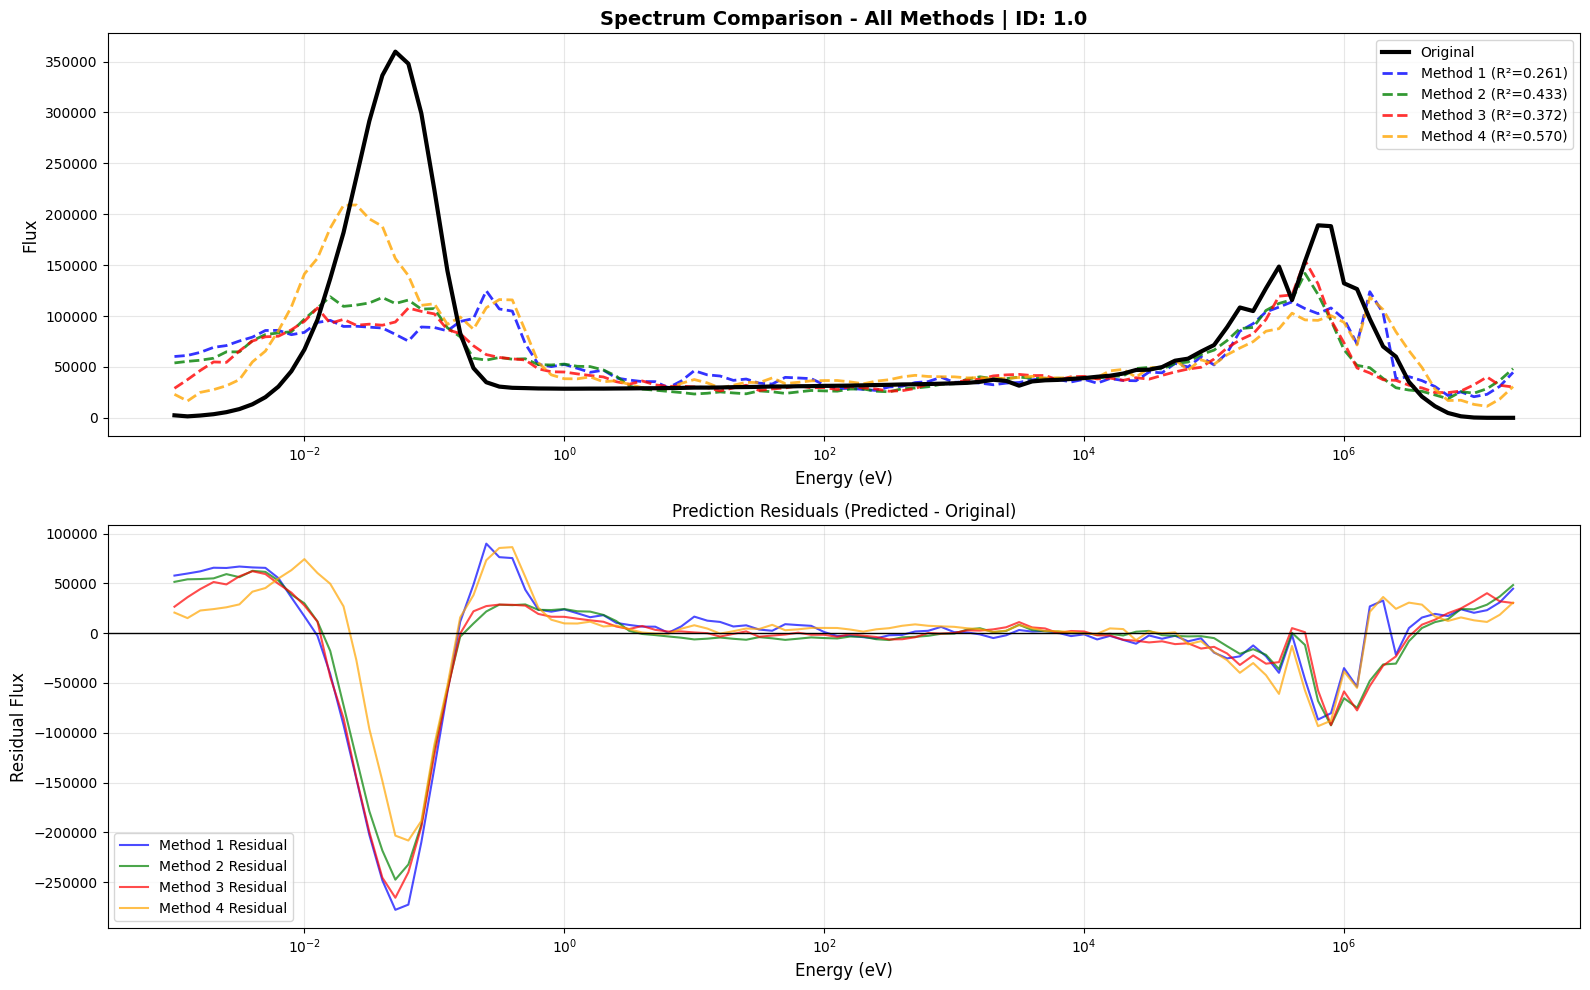

✅ Plotted spectrum ID: 1.0


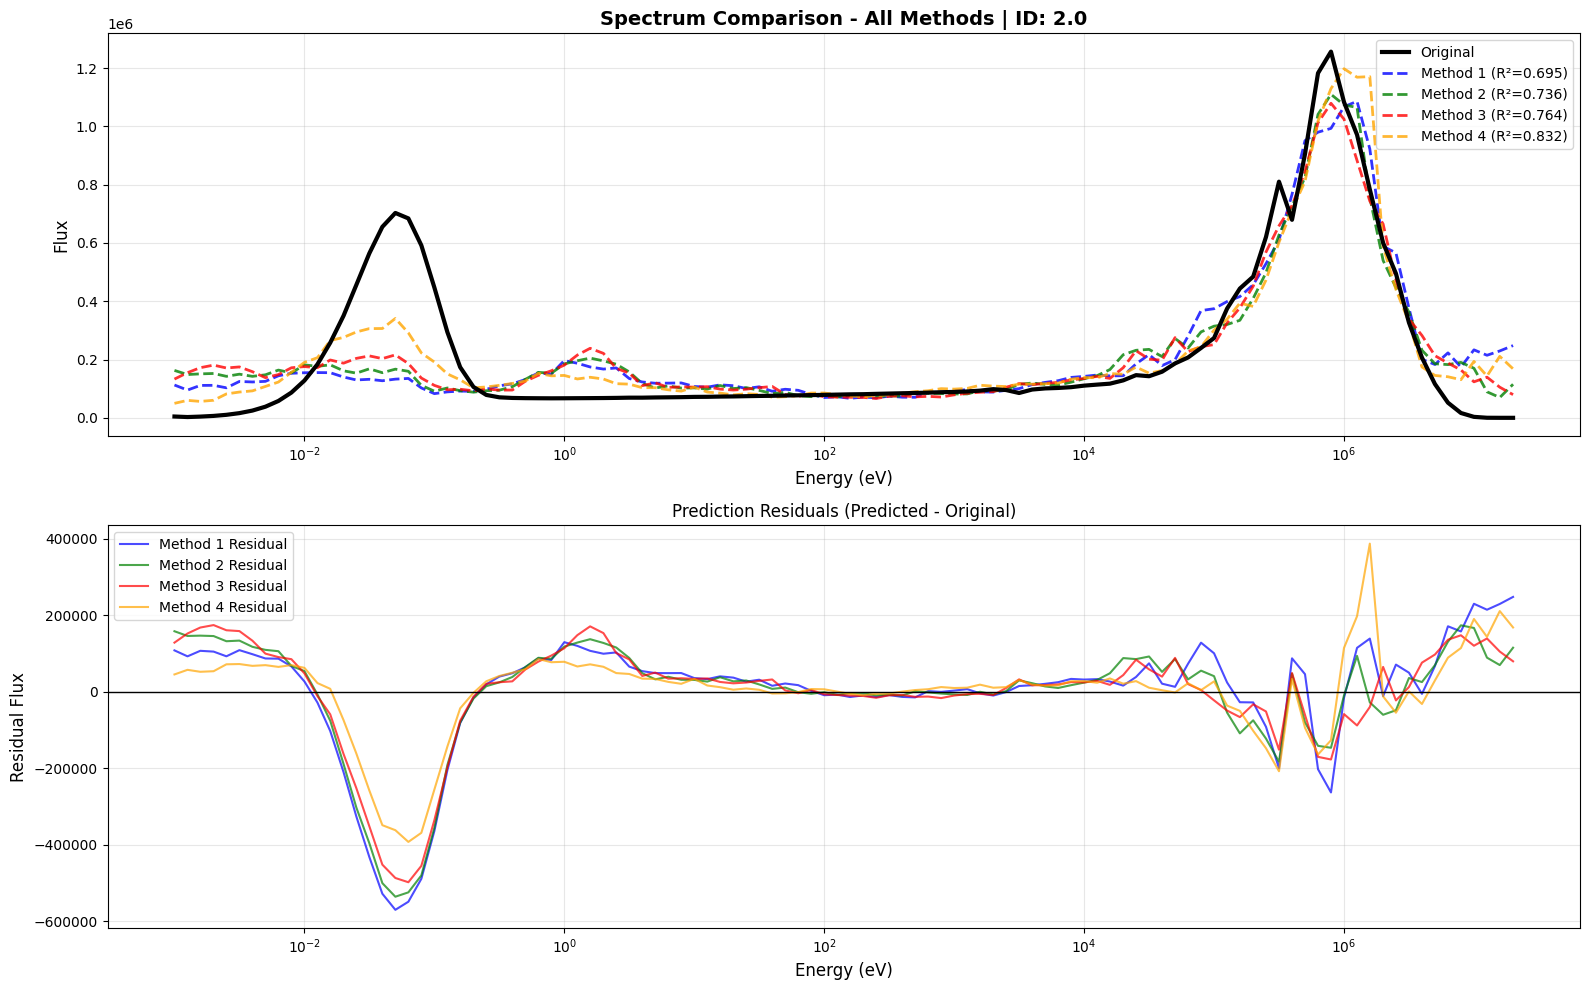

✅ Plotted spectrum ID: 2.0


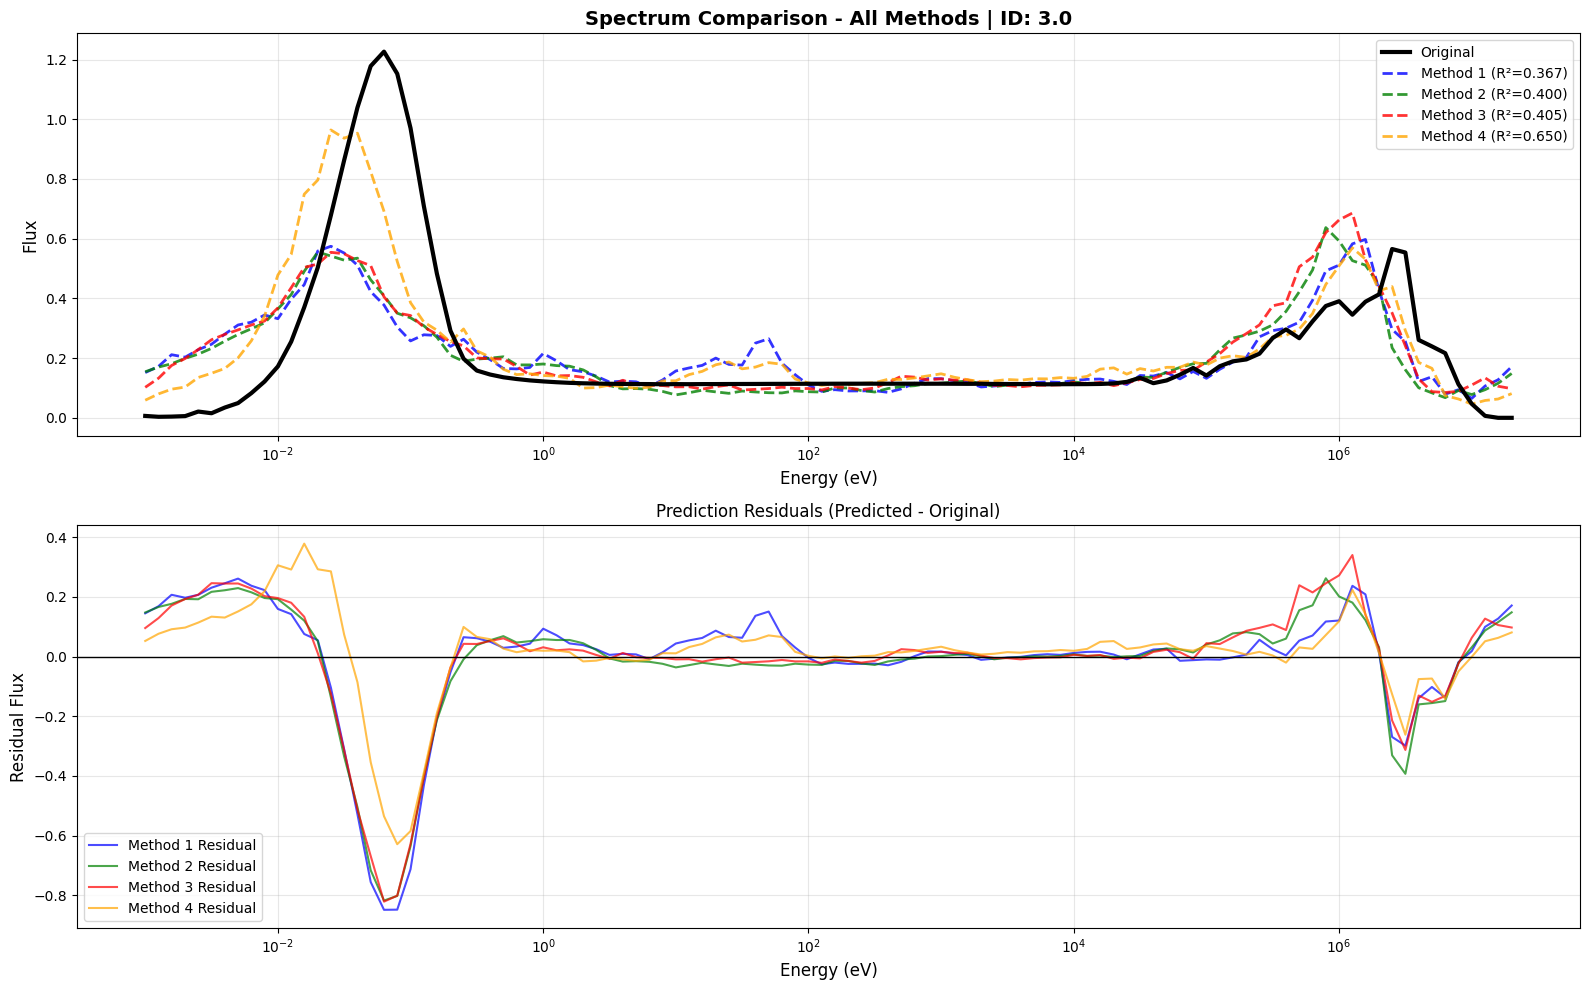

✅ Plotted spectrum ID: 3.0


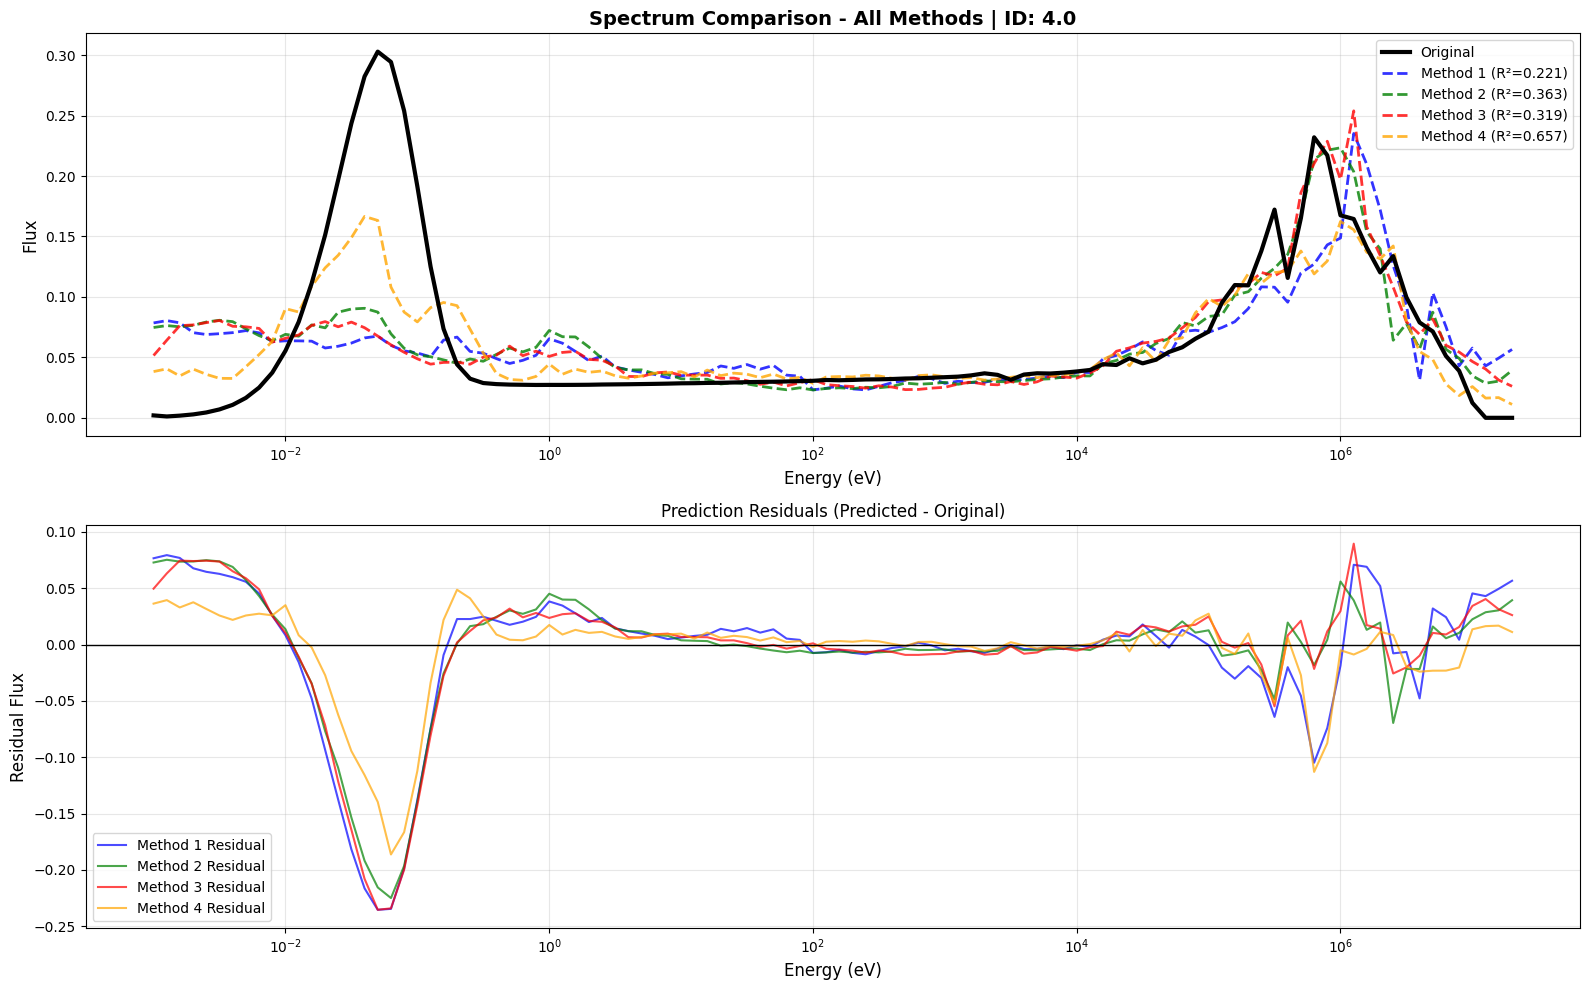

✅ Plotted spectrum ID: 4.0


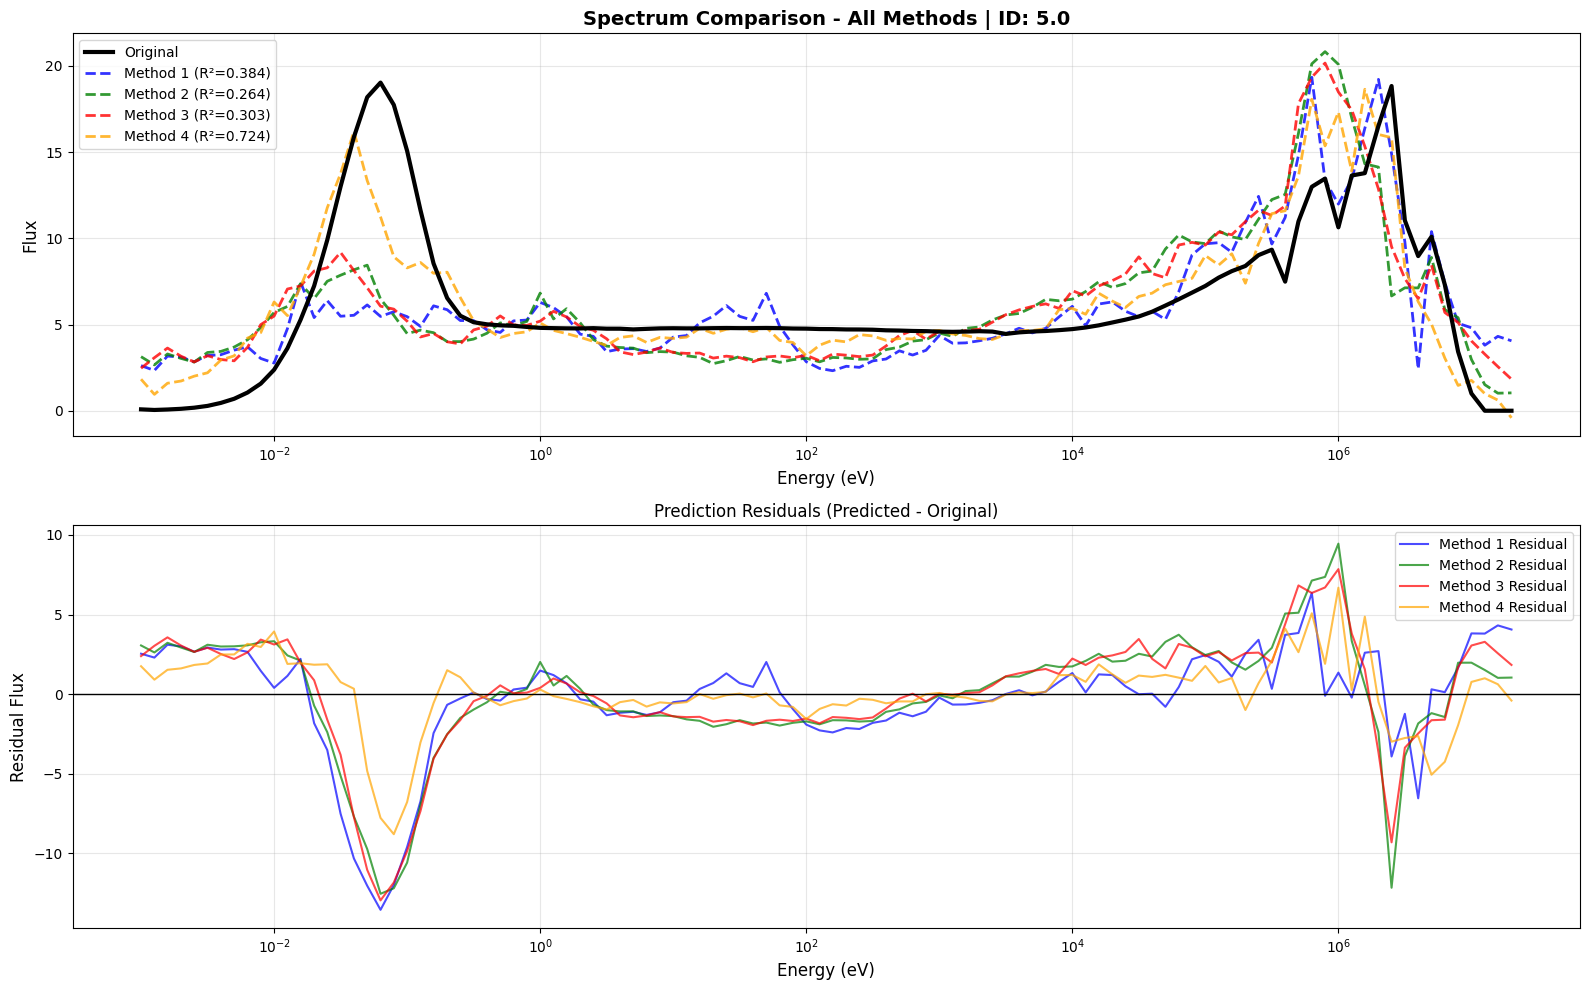

✅ Plotted spectrum ID: 5.0

✅ All comparison results saved to 'all_methods_comparison.csv'
✅ Individual plots saved as 'comparison_spectrum_[ID].png'

📊 SUMMARY STATISTICS:
Average R² - Method 1: 0.3855
Average R² - Method 2: 0.4392
Average R² - Method 3: 0.4327
Average R² - Method 4: 0.6865

Average MSE - Method 1: 5.4891e+09
Average MSE - Method 2: 4.6628e+09
Average MSE - Method 3: 4.3058e+09
Average MSE - Method 4: 3.0476e+09


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import find_peaks

# --------------------------
# ENERGY BINS
# --------------------------
energy_bins = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

# --------------------------
# COMMON FUNCTIONS
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0, random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

# --------------------------
# AUGMENTATION FUNCTIONS
# --------------------------
def add_gaussian_noise(spectrum, noise_level=0.05):
    noise = np.random.normal(0, noise_level * np.maximum(spectrum, 0.01), size=spectrum.shape)
    return np.clip(spectrum + noise, 0, None)

def multiplicative_noise(spectrum, scale_range=(0.95, 1.05)):
    return spectrum * np.random.uniform(*scale_range)

def smooth_spectrum(spectrum, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(spectrum, kernel, mode="same")

def random_peak_scaling(spectrum, prominence=0.05, scale_range=(0.8, 1.3)):
    peaks, _ = find_peaks(spectrum, prominence=prominence * np.max(spectrum))
    if len(peaks) == 0: return spectrum
    aug = spectrum.copy()
    selected_peaks = np.random.choice(peaks, size=np.random.randint(1, min(len(peaks), 3)+1), replace=False)
    for p in selected_peaks:
        scale = np.random.uniform(*scale_range)
        aug[p] *= scale
        if p > 0: aug[p-1] *= (scale+1)/2
        if p < len(aug)-1: aug[p+1] *= (scale+1)/2
    return np.clip(aug, 0, None)

def augment_sequentially(spectrum):
    aug = random_peak_scaling(spectrum)
    aug = smooth_spectrum(aug)
    aug = multiplicative_noise(aug)
    aug = add_gaussian_noise(aug)
    return np.clip(aug, 0, None)

def augment_training_data(train_df, spectrum_cols, n_augments=3):
    augmented_rows = []
    for _, row in train_df.iterrows():
        spectrum = row[spectrum_cols].values.astype(float)
        for _ in range(n_augments):
            augmented_row = row.copy()
            new_spectrum = augment_sequentially(spectrum)
            augmented_row[spectrum_cols] = new_spectrum
            augmented_rows.append(augmented_row)
    return pd.concat([train_df, pd.DataFrame(augmented_rows)], ignore_index=True)

# --------------------------
# LOAD DATA
# --------------------------
try:
    train_df_modified = pd.read_csv("Dataset_modified.csv")
    train_df_complete = pd.read_csv("complete_dataset.csv")
    test_df = pd.read_csv("Test_Dataset_modified.csv")
    print("✅ All dataset files loaded successfully")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Using dummy data for demonstration...")
    num_samples_train, num_samples_test = 100, 10
    num_counts, num_spectrum = 50, 104
    train_df_modified = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum + 1))
    train_df_modified.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    train_df_modified["spectrum_id"] = range(num_samples_train)
    train_df_complete = train_df_modified.copy()
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]

spectrum_cols = [c for c in train_df_modified.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df_modified.columns if c.startswith("count_")]

# Convert to numeric
train_df_modified[spectrum_cols] = train_df_modified[spectrum_cols].apply(pd.to_numeric, errors="coerce")
train_df_complete[spectrum_cols] = train_df_complete[spectrum_cols].apply(pd.to_numeric, errors="coerce")
test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Bad IDs to remove
remove_ids = {5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,
              48,49,51,52,53,54,55,56,57,58,
              68,70,74,75,77,78,79,81,82,
              86,89,90,91,92,96,97,98,99,100,
              102,106,107,108,110,111,112,113,114}

# --------------------------
# METHOD 1: Basic XGBoost (Dataset_modified.csv)
# --------------------------
print("=" * 60)
print("METHOD 1: Basic XGBoost (Dataset_modified.csv)")
print("=" * 60)

train1 = train_df_modified.copy()
train_counts_total = train1[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train1[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1
train1[count_cols] = train1[count_cols].div(train_counts_total, axis=0)
train1[spectrum_cols] = train1[spectrum_cols].div(train_spectrum_total, axis=0)

X_train1 = train1[count_cols].values
Y_train1 = train1[spectrum_cols].values

print("Training Method 1...")
models1 = train_xgb_multioutput(X_train1, Y_train1)
print("✅ Method 1 trained")

# --------------------------
# METHOD 2: Filtered XGBoost (Dataset_modified.csv)
# --------------------------
print("\n" + "=" * 60)
print("METHOD 2: Filtered XGBoost (Dataset_modified.csv, Bad IDs removed)")
print("=" * 60)

train2 = train_df_modified[~train_df_modified["spectrum_id"].isin(remove_ids)].copy()
train_counts_total = train2[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train2[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1
train2[count_cols] = train2[count_cols].div(train_counts_total, axis=0)
train2[spectrum_cols] = train2[spectrum_cols].div(train_spectrum_total, axis=0)

X_train2 = train2[count_cols].values
Y_train2 = train2[spectrum_cols].values

print("Training Method 2...")
models2 = train_xgb_multioutput(X_train2, Y_train2)
print("✅ Method 2 trained")

# --------------------------
# METHOD 3: Filtered + Augmented XGBoost (Dataset_modified.csv)
# --------------------------
print("\n" + "=" * 60)
print("METHOD 3: Filtered + Augmented XGBoost (Dataset_modified.csv)")
print("=" * 60)

train3 = train_df_modified[~train_df_modified["spectrum_id"].isin(remove_ids)].copy()
train_counts_total = train3[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train3[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1
train3[count_cols] = train3[count_cols].div(train_counts_total, axis=0)
train3[spectrum_cols] = train3[spectrum_cols].div(train_spectrum_total, axis=0)

print("Augmenting data...")
train3_aug = augment_training_data(train3, spectrum_cols, n_augments=5)
print(f"Augmented: {len(train3)} → {len(train3_aug)} samples")

X_train3 = train3_aug[count_cols].values
Y_train3 = train3_aug[spectrum_cols].values

print("Training Method 3...")
models3 = train_xgb_multioutput(X_train3, Y_train3)
print("✅ Method 3 trained")

# --------------------------
# METHOD 4: Basic XGBoost (complete_dataset.csv)
# --------------------------
print("\n" + "=" * 60)
print("METHOD 4: Basic XGBoost (complete_dataset.csv)")
print("=" * 60)

train4 = train_df_complete.copy()
train_counts_total = train4[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train4[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1
train4[count_cols] = train4[count_cols].div(train_counts_total, axis=0)
train4[spectrum_cols] = train4[spectrum_cols].div(train_spectrum_total, axis=0)

X_train4 = train4[count_cols].values
Y_train4 = train4[spectrum_cols].values

print("Training Method 4...")
models4 = train_xgb_multioutput(X_train4, Y_train4)
print("✅ Method 4 trained")

# --------------------------
# NORMALIZE TEST DATA
# --------------------------
test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# PREDICT AND COMPARE ALL METHODS
# --------------------------
print("\n" + "=" * 60)
print("GENERATING COMPARISON PLOTS")
print("=" * 60)

all_results = []

for idx, row in test_df.iterrows():
    spec_id = row["spectrum_id"]
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values

    # Get predictions from all methods
    y_pred1_norm = predict_xgb_multioutput(models1, x_test)[0]
    y_pred2_norm = predict_xgb_multioutput(models2, x_test)[0]
    y_pred3_norm = predict_xgb_multioutput(models3, x_test)[0]
    y_pred4_norm = predict_xgb_multioutput(models4, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true = y_true_norm * spectrum_total
    y_pred1 = y_pred1_norm * spectrum_total
    y_pred2 = y_pred2_norm * spectrum_total
    y_pred3 = y_pred3_norm * spectrum_total
    y_pred4 = y_pred4_norm * spectrum_total

    # Calculate metrics
    r2_1 = r2_score(y_true, y_pred1)
    r2_2 = r2_score(y_true, y_pred2)
    r2_3 = r2_score(y_true, y_pred3)
    r2_4 = r2_score(y_true, y_pred4)

    mse_1 = mean_squared_error(y_true, y_pred1)
    mse_2 = mean_squared_error(y_true, y_pred2)
    mse_3 = mean_squared_error(y_true, y_pred3)
    mse_4 = mean_squared_error(y_true, y_pred4)

    # Store results
    all_results.append({
        "spectrum_id": spec_id,
        "Method1_R2": r2_1, "Method1_MSE": mse_1,
        "Method2_R2": r2_2, "Method2_MSE": mse_2,
        "Method3_R2": r2_3, "Method3_MSE": mse_3,
        "Method4_R2": r2_4, "Method4_MSE": mse_4
    })

    # Create comparison plot
    plt.figure(figsize=(16, 10))

    # Main comparison plot
    plt.subplot(2, 1, 1)
    plt.semilogx(energy_bins, y_true, label="Original", color="black", linewidth=3, zorder=5)
    plt.semilogx(energy_bins, y_pred1, '--', label=f"Method 1 (R²={r2_1:.3f})", color="blue", linewidth=2, alpha=0.8)
    plt.semilogx(energy_bins, y_pred2, '--', label=f"Method 2 (R²={r2_2:.3f})", color="green", linewidth=2, alpha=0.8)
    plt.semilogx(energy_bins, y_pred3, '--', label=f"Method 3 (R²={r2_3:.3f})", color="red", linewidth=2, alpha=0.8)
    plt.semilogx(energy_bins, y_pred4, '--', label=f"Method 4 (R²={r2_4:.3f})", color="orange", linewidth=2, alpha=0.8)
    plt.title(f"Spectrum Comparison - All Methods | ID: {spec_id}", fontsize=14, fontweight='bold')
    plt.xlabel("Energy (eV)", fontsize=12)
    plt.ylabel("Flux", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(alpha=0.3, which="both")

    # Residuals plot
    plt.subplot(2, 1, 2)
    plt.semilogx(energy_bins, y_pred1 - y_true, label="Method 1 Residual", color="blue", linewidth=1.5, alpha=0.7)
    plt.semilogx(energy_bins, y_pred2 - y_true, label="Method 2 Residual", color="green", linewidth=1.5, alpha=0.7)
    plt.semilogx(energy_bins, y_pred3 - y_true, label="Method 3 Residual", color="red", linewidth=1.5, alpha=0.7)
    plt.semilogx(energy_bins, y_pred4 - y_true, label="Method 4 Residual", color="orange", linewidth=1.5, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.title("Prediction Residuals (Predicted - Original)", fontsize=12)
    plt.xlabel("Energy (eV)", fontsize=12)
    plt.ylabel("Residual Flux", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(alpha=0.3, which="both")

    plt.tight_layout()
    plt.savefig(f"comparison_spectrum_{spec_id}.png", dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Plotted spectrum ID: {spec_id}")

# --------------------------
# SAVE COMPARISON RESULTS
# --------------------------
results_df = pd.DataFrame(all_results)
results_df.to_csv("all_methods_comparison.csv", index=False)
print("\n" + "=" * 60)
print("✅ All comparison results saved to 'all_methods_comparison.csv'")
print("✅ Individual plots saved as 'comparison_spectrum_[ID].png'")
print("=" * 60)

# Summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"Average R² - Method 1: {results_df['Method1_R2'].mean():.4f}")
print(f"Average R² - Method 2: {results_df['Method2_R2'].mean():.4f}")
print(f"Average R² - Method 3: {results_df['Method3_R2'].mean():.4f}")
print(f"Average R² - Method 4: {results_df['Method4_R2'].mean():.4f}")
print(f"\nAverage MSE - Method 1: {results_df['Method1_MSE'].mean():.4e}")
print(f"Average MSE - Method 2: {results_df['Method2_MSE'].mean():.4e}")
print(f"Average MSE - Method 3: {results_df['Method3_MSE'].mean():.4e}")
print(f"Average MSE - Method 4: {results_df['Method4_MSE'].mean():.4e}")

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import find_peaks

# --------------------------
# ENERGY BINS
# --------------------------
energy_bins = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

# --------------------------
# COMMON FUNCTIONS
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0, random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

# --------------------------
# AUGMENTATION FUNCTIONS
# --------------------------
def add_gaussian_noise(spectrum, noise_level=0.05):
    noise = np.random.normal(0, noise_level * np.maximum(spectrum, 0.01), size=spectrum.shape)
    return np.clip(spectrum + noise, 0, None)

def multiplicative_noise(spectrum, scale_range=(0.95, 1.05)):
    return spectrum * np.random.uniform(*scale_range)

def smooth_spectrum(spectrum, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(spectrum, kernel, mode="same")

def random_peak_scaling(spectrum, prominence=0.05, scale_range=(0.8, 1.3)):
    peaks, _ = find_peaks(spectrum, prominence=prominence * np.max(spectrum))
    if len(peaks) == 0: return spectrum
    aug = spectrum.copy()
    selected_peaks = np.random.choice(peaks, size=np.random.randint(1, min(len(peaks), 3)+1), replace=False)
    for p in selected_peaks:
        scale = np.random.uniform(*scale_range)
        aug[p] *= scale
        if p > 0: aug[p-1] *= (scale+1)/2
        if p < len(aug)-1: aug[p+1] *= (scale+1)/2
    return np.clip(aug, 0, None)

def augment_sequentially(spectrum):
    aug = random_peak_scaling(spectrum)
    aug = smooth_spectrum(aug)
    aug = multiplicative_noise(aug)
    aug = add_gaussian_noise(aug)
    return np.clip(aug, 0, None)

def augment_training_data(train_df, spectrum_cols, n_augments=3):
    augmented_rows = []
    for _, row in train_df.iterrows():
        spectrum = row[spectrum_cols].values.astype(float)
        for _ in range(n_augments):
            augmented_row = row.copy()
            new_spectrum = augment_sequentially(spectrum)
            augmented_row[spectrum_cols] = new_spectrum
            augmented_rows.append(augmented_row)
    return pd.concat([train_df, pd.DataFrame(augmented_rows)], ignore_index=True)

# --------------------------
# LOAD DATA
# --------------------------
try:
    train_df_modified = pd.read_csv("Dataset_modified.csv")
    train_df_complete = pd.read_csv("complete_dataset.csv")
    test_df = pd.read_csv("Test_Dataset_modified.csv")
    print("✅ All dataset files loaded successfully")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Using dummy data for demonstration...")
    num_samples_train, num_samples_test = 100, 5  # only 5 test samples
    num_counts, num_spectrum = 50, 104
    train_df_modified = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum + 1))
    train_df_modified.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    train_df_modified["spectrum_id"] = range(num_samples_train)
    train_df_complete = train_df_modified.copy()
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]

spectrum_cols = [c for c in train_df_modified.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df_modified.columns if c.startswith("count_")]

# Convert to numeric
train_df_modified[spectrum_cols] = train_df_modified[spectrum_cols].apply(pd.to_numeric, errors="coerce")
train_df_complete[spectrum_cols] = train_df_complete[spectrum_cols].apply(pd.to_numeric, errors="coerce")
test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Bad IDs to remove
remove_ids = {5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,
              48,49,51,52,53,54,55,56,57,58,
              68,70,74,75,77,78,79,81,82,
              86,89,90,91,92,96,97,98,99,100,
              102,106,107,108,110,111,112,113,114}

# --------------------------
# TRAINING METHODS
# --------------------------
def prepare_and_train(df, name, augment=False):
    df = df.copy()
    train_counts_total = df[count_cols].sum(axis=1)
    train_counts_total[train_counts_total == 0] = 1
    train_spectrum_total = df[spectrum_cols].sum(axis=1)
    train_spectrum_total[train_spectrum_total == 0] = 1
    df[count_cols] = df[count_cols].div(train_counts_total, axis=0)
    df[spectrum_cols] = df[spectrum_cols].div(train_spectrum_total, axis=0)

    if augment:
        print("Augmenting data...")
        df = augment_training_data(df, spectrum_cols, n_augments=5)
        print(f"Augmented dataset size: {len(df)}")

    X = df[count_cols].values
    Y = df[spectrum_cols].values
    print(f"Training {name}...")
    models = train_xgb_multioutput(X, Y)
    print(f"✅ {name} trained")
    return models

print("=" * 60)
models1 = prepare_and_train(train_df_modified, "Method 1")
print("=" * 60)
models2 = prepare_and_train(train_df_modified[~train_df_modified["spectrum_id"].isin(remove_ids)], "Method 2")
print("=" * 60)
models3 = prepare_and_train(train_df_modified[~train_df_modified["spectrum_id"].isin(remove_ids)], "Method 3 (Augmented)", augment=True)
print("=" * 60)
models4 = prepare_and_train(train_df_complete, "Method 4")

# --------------------------
# NORMALIZE TEST DATA
# --------------------------
test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# PREDICT & COMPARE
# --------------------------
all_results = []

for idx, row in test_df.iterrows():
    spec_id = row["spectrum_id"]
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values

    spectrum_total = test_spectrum_total.iloc[idx]
    y_true = y_true_norm * spectrum_total

    preds = {
        1: predict_xgb_multioutput(models1, x_test)[0] * spectrum_total,
        2: predict_xgb_multioutput(models2, x_test)[0] * spectrum_total,
        3: predict_xgb_multioutput(models3, x_test)[0] * spectrum_total,
        4: predict_xgb_multioutput(models4, x_test)[0] * spectrum_total,
    }

    # Metrics
    all_results.append({
        "spectrum_id": spec_id,
        "Method1_R2": r2_score(y_true, preds[1]),
        "Method1_MSE": mean_squared_error(y_true, preds[1]),
        "Method2_R2": r2_score(y_true, preds[2]),
        "Method2_MSE": mean_squared_error(y_true, preds[2]),
        "Method3_R2": r2_score(y_true, preds[3]),
        "Method3_MSE": mean_squared_error(y_true, preds[3]),
        "Method4_R2": r2_score(y_true, preds[4]),
        "Method4_MSE": mean_squared_error(y_true, preds[4]),
    })

results_df = pd.DataFrame(all_results)
results_df.to_csv("all_methods_comparison.csv", index=False)

# --------------------------
# REGION-WISE ERRORS
# --------------------------
thermal_mask = energy_bins < 0.5
epithermal_mask = (energy_bins >= 0.5) & (energy_bins < 1e5)
fast_mask = energy_bins >= 1e5

region_errors = {m: {"thermal": [], "epithermal": [], "fast": [], "total": []} for m in range(1, 5)}

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true = y_true_norm * spectrum_total

    preds = {
        1: predict_xgb_multioutput(models1, x_test)[0] * spectrum_total,
        2: predict_xgb_multioutput(models2, x_test)[0] * spectrum_total,
        3: predict_xgb_multioutput(models3, x_test)[0] * spectrum_total,
        4: predict_xgb_multioutput(models4, x_test)[0] * spectrum_total,
    }

    true_sums = {
        "thermal": y_true[thermal_mask].sum(),
        "epithermal": y_true[epithermal_mask].sum(),
        "fast": y_true[fast_mask].sum(),
        "total": y_true.sum()
    }

    for m in range(1, 5):
        pred = preds[m]
        pred_sums = {
            "thermal": pred[thermal_mask].sum(),
            "epithermal": pred[epithermal_mask].sum(),
            "fast": pred[fast_mask].sum(),
            "total": pred.sum()
        }
        for reg in true_sums:
            err = abs(pred_sums[reg] - true_sums[reg]) / (true_sums[reg] + 1e-12)
            region_errors[m][reg].append(err)

# --------------------------
# PRINT FINAL PERFORMANCE
# --------------------------
print("\n📊 FINAL PERFORMANCE (averaged over 5 test cases):")
for m in range(1, 5):
    avg_r2 = results_df[f"Method{m}_R2"].mean()
    avg_thermal = np.mean(region_errors[m]["thermal"])
    avg_epithermal = np.mean(region_errors[m]["epithermal"])
    avg_fast = np.mean(region_errors[m]["fast"])
    avg_total = np.mean(region_errors[m]["total"])
    print(f"\n🔹 Method {m}:")
    print(f"   Avg R²         = {avg_r2:.4f}")
    print(f"   Thermal Error   = {avg_thermal:.2%}")
    print(f"   Epithermal Error= {avg_epithermal:.2%}")
    print(f"   Fast Error      = {avg_fast:.2%}")
    print(f"   Total Error     = {avg_total:.2%}")


✅ All dataset files loaded successfully
Training Method 1...
✅ Method 1 trained
Training Method 2...
✅ Method 2 trained
Augmenting data...
Augmented dataset size: 360
Training Method 3 (Augmented)...
✅ Method 3 (Augmented) trained
Training Method 4...
✅ Method 4 trained

📊 FINAL PERFORMANCE (averaged over 5 test cases):

🔹 Method 1:
   Avg R²         = 0.3855
   Thermal Error   = 30.64%
   Epithermal Error= 17.89%
   Fast Error      = 9.30%
   Total Error     = 5.28%

🔹 Method 2:
   Avg R²         = 0.4392
   Thermal Error   = 26.71%
   Epithermal Error= 11.48%
   Fast Error      = 10.43%
   Total Error     = 5.84%

🔹 Method 3:
   Avg R²         = 0.4339
   Thermal Error   = 26.40%
   Epithermal Error= 12.00%
   Fast Error      = 14.12%
   Total Error     = 4.86%

🔹 Method 4:
   Avg R²         = 0.6865
   Thermal Error   = 10.82%
   Epithermal Error= 13.92%
   Fast Error      = 8.84%
   Total Error     = 4.22%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Load dataset
# -----------------------
df = pd.read_csv("/content/Dataset_modified.csv")

# Spectrum columns
spectrum_cols = [f"spectrum_value_{i}" for i in range(1, 105)]
y = df[spectrum_cols].values
energy_sources = df["Energy_Source"].values
spectrum_ids = df["spectrum_id"].values

# Energy bins
energy_bins = np.array([
    1.00E-03, 1.26E-03, 1.58E-03, 2.00E-03, 2.51E-03, 3.16E-03, 3.98E-03, 5.01E-03, 6.31E-03, 7.94E-03,
    1.00E-02, 1.26E-02, 1.58E-02, 2.00E-02, 2.51E-02, 3.16E-02, 3.98E-02, 5.01E-02, 6.31E-02, 7.94E-02,
    1.00E-01, 1.26E-01, 1.58E-01, 2.00E-01, 2.51E-01, 3.16E-01, 3.98E-01, 5.01E-01, 6.31E-01, 7.94E-01,
    1.00E+00, 1.26E+00, 1.58E+00, 2.00E+00, 2.51E+00, 3.16E+00, 3.98E+00, 5.01E+00, 6.31E+00, 7.94E+00,
    1.00E+01, 1.26E+01, 1.58E+01, 2.00E+01, 2.51E+01, 3.16E+01, 3.98E+01, 5.01E+01, 6.31E+01, 7.94E+01,
    1.00E+02, 1.26E+02, 1.58E+02, 2.00E+02, 2.51E+02, 3.16E+02, 3.98E+02, 5.01E+02, 6.31E+02, 7.94E+02,
    1.00E+03, 1.26E+03, 1.58E+03, 2.00E+03, 2.51E+03, 3.16E+03, 3.98E+03, 5.01E+03, 6.31E+03, 7.94E+03,
    1.00E+04, 1.26E+04, 1.58E+04, 2.00E+04, 2.51E+04, 3.16E+04, 3.98E+04, 5.01E+04, 6.31E+04, 7.94E+04,
    1.00E+05, 1.26E+05, 1.58E+05, 2.00E+05, 2.51E+05, 3.16E+05, 3.98E+05, 5.01E+05, 6.31E+05, 7.94E+05,
    1.00E+06, 1.26E+06, 1.58E+06, 2.00E+06, 2.51E+06, 3.16E+06, 3.98E+06, 5.01E+06, 6.31E+06, 7.94E+06,
    1.00E+07, 1.26E+07, 1.58E+07, 2.00E+07
])

# -----------------------
# Plot spectra in 3 per row
# -----------------------
n_samples = len(y)
n_cols = 3
n_rows = int(np.ceil(n_samples / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # make it easier to index

for i in range(n_samples):
    ax = axes[i]
    ax.plot(energy_bins, y[i], 'k-', linewidth=2)
    ax.set_xscale("log")
    ax.set_ylabel("Spectrum Value")
    ax.set_title(f"id: {spectrum_ids[i]} ({energy_sources[i]})")
    ax.grid(True, which="both", alpha=0.3)

# Hide any empty subplots
for j in range(n_samples, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import find_peaks

# --------------------------
# ENERGY BINS
# --------------------------
energy_bins = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

# --------------------------
# COMMON FUNCTIONS
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0, random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

# --------------------------
# AUGMENTATION FUNCTIONS
# --------------------------
def add_gaussian_noise(spectrum, noise_level=0.05):
    noise = np.random.normal(0, noise_level * np.maximum(spectrum, 0.01), size=spectrum.shape)
    return np.clip(spectrum + noise, 0, None)

def multiplicative_noise(spectrum, scale_range=(0.95, 1.05)):
    return spectrum * np.random.uniform(*scale_range)

def smooth_spectrum(spectrum, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(spectrum, kernel, mode="same")

def random_peak_scaling(spectrum, prominence=0.05, scale_range=(0.8, 1.3)):
    peaks, _ = find_peaks(spectrum, prominence=prominence * np.max(spectrum))
    if len(peaks) == 0: return spectrum
    aug = spectrum.copy()
    selected_peaks = np.random.choice(peaks, size=np.random.randint(1, min(len(peaks), 3)+1), replace=False)
    for p in selected_peaks:
        scale = np.random.uniform(*scale_range)
        aug[p] *= scale
        if p > 0: aug[p-1] *= (scale+1)/2
        if p < len(aug)-1: aug[p+1] *= (scale+1)/2
    return np.clip(aug, 0, None)

def augment_sequentially(spectrum):
    aug = random_peak_scaling(spectrum)
    aug = smooth_spectrum(aug)
    aug = multiplicative_noise(aug)
    aug = add_gaussian_noise(aug)
    return np.clip(aug, 0, None)

def augment_training_data(train_df, spectrum_cols, n_augments=3):
    augmented_rows = []
    for _, row in train_df.iterrows():
        spectrum = row[spectrum_cols].values.astype(float)
        for _ in range(n_augments):
            augmented_row = row.copy()
            new_spectrum = augment_sequentially(spectrum)
            augmented_row[spectrum_cols] = new_spectrum
            augmented_rows.append(augmented_row)
    return pd.concat([train_df, pd.DataFrame(augmented_rows)], ignore_index=True)

# --------------------------
# LOAD DATA
# --------------------------
try:
    train_df_modified = pd.read_csv("Dataset_modified.csv")
    train_df_complete = pd.read_csv("complete_dataset.csv")
    test_df = pd.read_csv("Test_Dataset_modified.csv")
    print("✅ All dataset files loaded successfully")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Using dummy data for demonstration...")
    num_samples_train, num_samples_test = 100, 5
    num_counts, num_spectrum = 50, 104
    train_df_modified = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum + 1))
    train_df_modified.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    train_df_modified["spectrum_id"] = range(num_samples_train)
    train_df_complete = train_df_modified.copy()
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]

spectrum_cols = [c for c in train_df_modified.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df_modified.columns if c.startswith("count_")]

# Convert to numeric
train_df_modified[spectrum_cols] = train_df_modified[spectrum_cols].apply(pd.to_numeric, errors="coerce")
train_df_complete[spectrum_cols] = train_df_complete[spectrum_cols].apply(pd.to_numeric, errors="coerce")
test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Bad IDs to remove
remove_ids = {5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,
              48,49,51,52,53,54,55,56,57,58,
              68,70,74,75,77,78,79,81,82,
              86,89,90,91,92,96,97,98,99,100,
              102,106,107,108,110,111,112,113,114}

# --------------------------
# TRAINING METHODS
# --------------------------
def prepare_and_train(df, name, augment=False):
    df = df.copy()
    train_counts_total = df[count_cols].sum(axis=1)
    train_counts_total[train_counts_total == 0] = 1
    train_spectrum_total = df[spectrum_cols].sum(axis=1)
    train_spectrum_total[train_spectrum_total == 0] = 1
    df[count_cols] = df[count_cols].div(train_counts_total, axis=0)
    df[spectrum_cols] = df[spectrum_cols].div(train_spectrum_total, axis=0)

    if augment:
        print("Augmenting data...")
        df = augment_training_data(df, spectrum_cols, n_augments=5)
        print(f"Augmented dataset size: {len(df)}")

    X = df[count_cols].values
    Y = df[spectrum_cols].values
    print(f"Training {name}...")
    models = train_xgb_multioutput(X, Y)
    print(f"✅ {name} trained")
    return models

print("=" * 60)
models1 = prepare_and_train(train_df_modified, "Method 1")
print("=" * 60)
models2 = prepare_and_train(train_df_modified[~train_df_modified["spectrum_id"].isin(remove_ids)], "Method 2")
print("=" * 60)
models3 = prepare_and_train(train_df_modified[~train_df_modified["spectrum_id"].isin(remove_ids)], "Method 3 (Augmented)", augment=True)
print("=" * 60)
models4 = prepare_and_train(train_df_complete, "Method 4")

# --------------------------
# NORMALIZE TEST DATA
# --------------------------
test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# COMPUTE METRICS FOR SPECIFIC IDS (2 and 5)
# --------------------------
thermal_mask = energy_bins < 0.5
epithermal_mask = (energy_bins >= 0.5) & (energy_bins < 1e5)
fast_mask = energy_bins >= 1e5

target_ids = [2, 5]  # only compute for these
detailed_results = []

for idx, row in test_df.iterrows():
    try:
        spec_id_num = int(str(row["spectrum_id"]).replace("test_", ""))
    except:
        continue
    if spec_id_num not in target_ids:
        continue

    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true = y_true_norm * spectrum_total

    preds = {
        1: predict_xgb_multioutput(models1, x_test)[0] * spectrum_total,
        2: predict_xgb_multioutput(models2, x_test)[0] * spectrum_total,
        3: predict_xgb_multioutput(models3, x_test)[0] * spectrum_total,
        4: predict_xgb_multioutput(models4, x_test)[0] * spectrum_total,
    }

    true_sums = {
        "thermal": y_true[thermal_mask].sum(),
        "epithermal": y_true[epithermal_mask].sum(),
        "fast": y_true[fast_mask].sum(),
        "total": y_true.sum()
    }

    for m in range(1, 5):
        pred = preds[m]
        pred_sums = {
            "thermal": pred[thermal_mask].sum(),
            "epithermal": pred[epithermal_mask].sum(),
            "fast": pred[fast_mask].sum(),
            "total": pred.sum()
        }

        rel_errors = {
            reg: 100 * abs(pred_sums[reg] - true_sums[reg]) / (true_sums[reg] + 1e-12)
            for reg in true_sums
        }

        detailed_results.append({
            "Test Case": f"Test {1 if spec_id_num == 2 else 2}",
            "Method": ["Raw Data", "Cleaned Data", "Augmented Data", "Expanded Data"][m - 1],
            "R²": round(r2_score(y_true, pred), 4),
            "MSE": round(mean_squared_error(y_true, pred), 4),
            "Rel. Error Thermal (%)": round(rel_errors["thermal"], 2),
            "Rel. Error Epithermal (%)": round(rel_errors["epithermal"], 2),
            "Rel. Error Fast (%)": round(rel_errors["fast"], 2),
            "Rel. Error Total (%)": round(rel_errors["total"], 2),
        })

# --------------------------
# DISPLAY RESULTS
# --------------------------
df_results = pd.DataFrame(detailed_results)
print("\n================ Detailed Metrics for Test 1 (ID=2) and Test 2 (ID=5) ================\n")
print(df_results.to_string(index=False))
df_results.to_csv("detailed_results_test1_test2.csv", index=False)
print("\n✅ Results saved to 'detailed_results_test1_test2.csv'")


✅ All dataset files loaded successfully
Training Method 1...
✅ Method 1 trained
Training Method 2...
✅ Method 2 trained
Augmenting data...
Augmented dataset size: 360
Training Method 3 (Augmented)...
✅ Method 3 (Augmented) trained
Training Method 4...
✅ Method 4 trained

================ Detailed Metrics for Test 1 (ID=2) and Test 2 (ID=5) ================

Empty DataFrame
Columns: []
Index: []

✅ Results saved to 'detailed_results_test1_test2.csv'


/tmp/ipython-input-4018228108.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11)
/tmp/ipython-input-4018228108.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11)
/tmp/ipython-input-4018228108.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11)
/tmp/ipython-input-4018228108.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11)
/tmp/ipython-input-4018228108.py:39: UserWarning: No artists with labels

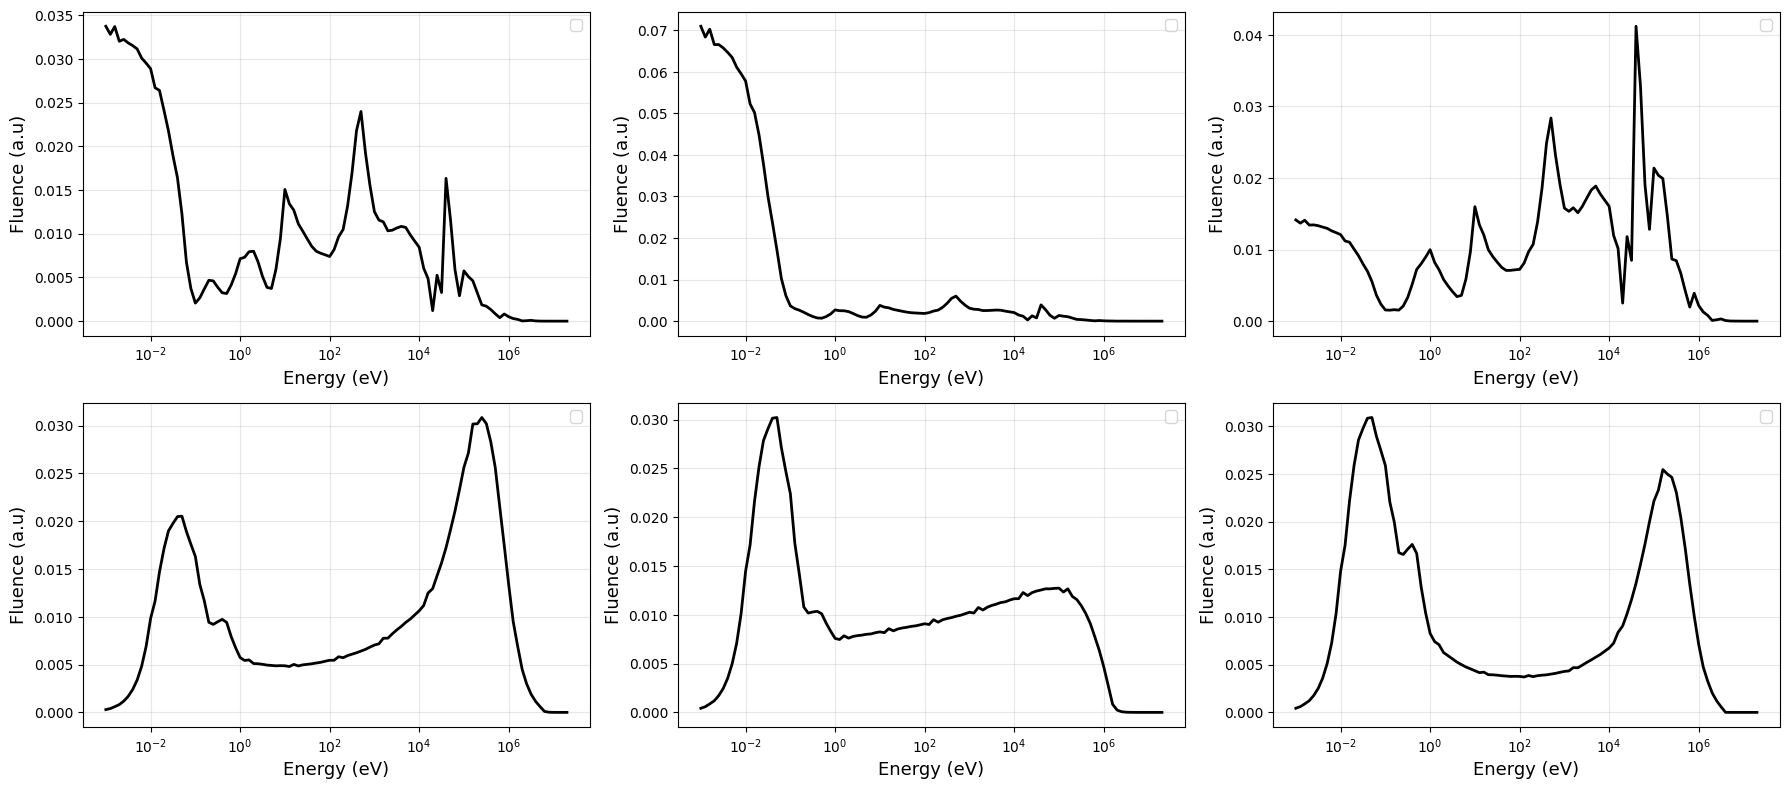

In [10]:
# --------------------------
# PLOT SPECIFIC TRAINING SPECTRA (REMOVED vs KEPT)
# --------------------------

# Define the spectrum IDs you want to visualize
removed_ids_train = [22, 23, 24]
kept_ids_train = [43, 44, 45]

# Prepare subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

def plot_train_spectrum(ax, spectrum_id, title_prefix):
    """Plot a training spectrum (true vs predicted)."""
    # Get the spectrum row
    row = train_df[train_df["spectrum_id"] == spectrum_id].iloc[0]

    # Extract input and output values
    x_train = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_train)[0]

    # Denormalize (convert back to actual fluence)
    spectrum_total = train_spectrum_total.loc[train_df["spectrum_id"] == spectrum_id].values[0]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    # Compute R²
    r2 = r2_score(y_true_actual, y_pred_actual)

    # Plot original vs predicted spectrum
    ax.semilogx(energy_bins, y_true_actual, color="black", linewidth=2)


    # Labels and formatting
    ax.set_xlabel("Energy (eV)", fontsize=13)
    ax.set_ylabel("Fluence (a.u)", fontsize=13)

    ax.legend(fontsize=11)
    ax.grid(alpha=0.3, which="both")

# --- Plot removed spectra (top row)
for i, spectrum_id in enumerate(removed_ids_train):
    plot_train_spectrum(axes[0, i], spectrum_id, "Removed (Train)")

# --- Plot kept spectra (bottom row)
for i, spectrum_id in enumerate(kept_ids_train):
    plot_train_spectrum(axes[1, i], spectrum_id, "Kept (Train)")

# Adjust layout and display
plt.tight_layout()
plt.show()
